# Scratch pad for random code snippets 

In [6]:
import numpy as np
import pymongo
import pandas as pd
from scipy.stats import ks_2samp, describe, skew
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import copy
import seaborn as sns
from scipy import stats
from ast import literal_eval

pd.options.display.max_columns = 500

In [2]:
#read in timit_master.csv
path = '../../data/timit_master.csv'
df = pd.read_csv(path, sep=',',
             dtype={
                 'start_word' : np.int,
                 'end_word': np.int,
                 'word': np.str,
                 'sample_id': np.str,
                 'speaker_id': np.str,
                 'start_phoneme': np.int,
                 'end_phoneme': np.int,
                 'arpabet': np.str,
                 'ipa': str,
                 'filename': np.str,
                 'index_phoneme': np.int
        })

run_name = 'uniform_dist'

# Functions

In [3]:
def acceptable_range(distro_list):
    #do full acceptable radius calc is there is more than 1 value present
    if len(distro_list) > 1:
        statistics = describe(distro_list)
        mean_value = statistics.mean
        min_radius = abs(mean_value - statistics.minmax[0])
        max_radius = abs(mean_value - statistics.minmax[1])

        if min_radius > max_radius:
            radius = min_radius
        else:
            radius = max_radius
    else:
        #set a place holder to radius to alert us later to apply average for speaker
        radius = -1.0
        
    return radius

In [4]:
def acceptable_stdev(distro_list):
    #do full acceptable radius calc is there is more than 1 value present
    if len(distro_list) > 1:
        statistics = describe(distro_list)
        radius = np.sqrt(statistics.variance)
    else:
        #set a place holder to radius to alert us later to apply average for speaker
        radius = -1.0
        
    return radius

# Read in data & begin manipulation

In [161]:
#area_distros = pd.read_csv('experiment_data/timit_all_augmented.csv')
area_distros = pd.read_csv('experiment_data/timit_train_augmented.csv')
area_distros['distro'] = area_distros['distro'].apply(literal_eval)
area_distros = area_distros.reset_index()
area_distros = area_distros.drop(columns=['index', 'prev_index'])

In [162]:
#rewindow the data to account for non-uniform number of windows
rewin_groups = area_distros.groupby(['speaker_id', 'label'])
rewindowed = []
for key, group in tqdm(rewin_groups):
    #calc each physical window percentile
    max_window = group['window'].max()
    percent_per_window = 1.0 / max_window
    
    group['window_percentile'] = group['window'] * percent_per_window
    
    #find the inner percentiles
    for search_percentile in [0.0 , 0.25, 0.50, 0.75, 1.0]:
        #walk through windows and linearily interpulate the 0.25, 0.5, 0.75 percentile marks
        for index in range(0, max_window):
            if group[group['window'] == index]['window_percentile'].values[0] <= search_percentile and \
            group[group['window'] == index + 1]['window_percentile'].values[0] >= search_percentile:
                lower_group = group[(group['window'] == index)] 
                upper_group = group[(group['window'] == index + 1)]
                merged = lower_group.merge(upper_group[['distro', 'window_percentile', 'dimension']], \
                                    left_on=['dimension'], right_on=['dimension'], \
                                    suffixes=('_lower', '_upper'))
                tmp = merged[['window_percentile_lower', 'distro_lower', \
                                      'window_percentile_upper', 'distro_upper']].values
                #linear approx each row
                distro_col = []
                for x_lower, y_lower, x_upper, y_upper in tmp:
                    #deal with the list of distros
                    result = []
                    for distro_index in range(0, len(y_lower)):
                        #deal with multiple samples of variable window length
                        if distro_index < len(y_upper):
                            slope = (y_upper[distro_index] - y_lower[distro_index]) /\
                                (x_upper - x_lower)
                        #find search percentile
                        result.append(slope * (search_percentile - x_lower) + y_lower[distro_index])
                    distro_col.append(result)
                #build df for reconstruction
                merged['distro'] = distro_col
                merged['window_percentile'] = search_percentile
                merged = merged[['speaker_id', 'label', 'window', 'dimension', 'distro', 'window_percentile']]
                rewindowed.append(merged)
df_tmp = pd.concat(rewindowed, ignore_index=True)

#calc stats
area_distros['distro_mu'] = area_distros.distro.apply(lambda x: np.mean(x))
area_distros['distro_acc_range'] = area_distros.distro.apply(lambda x: \
                                                        acceptable_range(x))
area_distros['distro_acc_stdev'] = area_distros.distro.apply(lambda x: \
                                                        acceptable_stdev(x))
if 'index' in area_distros.columns:
    area_distros = area_distros.drop(columns=['index'])
#calculate general speaker accuracy ranges
acc_ranges = area_distros[area_distros.distro_acc_range != -1.0]

  0%|          | 0/7577 [00:00<?, ?it/s]/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
  0%|          | 3/7577 [00:00<14:35,  8.65it/s]/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
100%|██████████| 7577/7577 [05:17<00:00, 23.88it/s]


In [163]:
#calc stats
area_distros['distro_mu'] = area_distros.distro.apply(lambda x: np.mean(x))
area_distros['distro_acc_range'] = area_distros.distro.apply(lambda x: \
                                                        acceptable_range(x))
area_distros['distro_acc_stdev'] = area_distros.distro.apply(lambda x: \
                                                        acceptable_stdev(x))
if 'index' in area_distros.columns:
    area_distros = area_distros.drop(columns=['index'])
#calculate general speaker accuracy ranges
acc_ranges = area_distros[area_distros.distro_acc_range != -1.0]

Need one last decorator for the dataset, the average stdev for a speaker across bigram for use when a bigram is only seen once

### Area_distros Decorating

In [164]:
acc_ranges['acc_percent'] = acc_ranges['distro_acc_range'] / acc_ranges['distro_mu']

#getting rid of outliers
while abs(acc_ranges.distro_acc_stdev.skew()) > 2.8:
    remove_index = acc_ranges.distro_acc_stdev.idxmax()
    acc_ranges = acc_ranges.drop(remove_index)
print('Accuracy Range skew: ', acc_ranges.distro_acc_stdev.skew())

while abs(acc_ranges.distro_mu.skew()) > 2.8:
    remove_index = acc_ranges.distro_mu.idxmax()
    acc_ranges = acc_ranges.drop(remove_index)
print('Mu skew: ', acc_ranges.distro_mu.skew())

#adding stats
ave_stdev = acc_ranges.groupby('speaker_id').agg('mean')[['distro_acc_stdev']]
ave_stdev.reset_index(level=0, inplace=True)
ave_stdev = ave_stdev.rename(columns={'distro_acc_stdev':'ave_stdev'})
area_distros = area_distros.join(ave_stdev.set_index('speaker_id'), on='speaker_id')
area_distros['stdev'] = area_distros.apply(lambda row: row['distro_acc_stdev'] if row['distro_acc_stdev'] > 0 else row['ave_stdev'], axis=1)
area_distros['stdev_used'] = area_distros.apply(lambda row: 'local' if row['distro_acc_stdev'] > 0 else 'ave', axis=1)
#adding distance thresholds
area_distros['dist_50'] =area_distros['stdev'] * stats.norm.ppf(0.75)    #center 50% of data
area_distros['dist_90'] =area_distros['stdev'] * stats.norm.ppf(0.95)    #center 90% of data
area_distros['dist_95'] =area_distros['stdev'] * stats.norm.ppf(0.975)   #center 95% of data
area_distros['dist_99'] =area_distros['stdev'] * 3                       #center 99.865% of data

area_distros

/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Accuracy Range skew:  2.799913786060946
Mu skew:  2.7976999941290788


speaker_id sex     label  window  dimension                distro  \
0           FALK0   f  aɪ -- k̚       0          0   [2.066158881053493]   
1           FALK0   f  aɪ -- k̚       0          1    [0.74478866064967]   
2           FALK0   f  aɪ -- k̚       0          2  [1.0703744716990622]   
3           FALK0   f  aɪ -- k̚       0          3  [3.0052241716359034]   
4           FALK0   f  aɪ -- k̚       0          4  [3.8171555866721447]   
...           ...  ..       ...     ...        ...                   ...   
531505      MVRW0   f    θ -- ɚ       2         10   [5.360500742252299]   
531506      MVRW0   f    θ -- ɚ       2         11   [7.115935292316069]   
531507      MVRW0   f    θ -- ɚ       2         12  [11.735223159300093]   
531508      MVRW0   f    θ -- ɚ       2         13  [20.342251035156757]   
531509      MVRW0   f    θ -- ɚ       2         14  [28.548576424211767]   

       dataset  distro_mu  distro_acc_range  distro_acc_stdev  ave_stdev  \
0         fake   2.066159              -1.0              -1.0   4.890127   
1         fake   0.744789              -1.0              -1.0   4.890127   
2         fake   1.070374              -1.0              -1.0   4.890127   
3         fake   3.005224              -1.0              -1.0   4.890127   
4         fake   3.817156              -1.0              -1.0   4.890127   
...        ...        ...               ...               ...        ...   
531505    fake   5.360501              -1.0              -1.0   8.109040   
531506    fake   7.115935              -1.0              -1.0   8.109040   
531507    fake  11.735223              -1.0              -1.0   8.109040   
531508    fake  20.342251              -1.0              -1.0   8.109040   
531509    fake  28.548576              -1.0              -1.0   8.109040   

           stdev stdev_used   dist_50    dist_90    dist_95    dist_99  
0       4.890127        ave  3.298341   8.043543   9.584473  14.670381  
1       4.890127        ave  3.298341   8.043543   9.584473  14.670381  
2       4.890127        ave  3.298341   8.043543   9.584473  14.670381  
3       4.890127        ave  3.298341   8.043543   9.584473  14.670381  
4       4.890127        ave  3.298341   8.043543   9.584473  14.670381  
...          ...        ...       ...        ...        ...        ...  
531505  8.109040        ave  5.469464  13.338184  15.893426  24.327120  
531506  8.109040        ave  5.469464  13.338184  15.893426  24.327120  
531507  8.109040        ave  5.469464  13.338184  15.893426  24.327120  
531508  8.109040        ave  5.469464  13.338184  15.893426  24.327120  
531509  8.109040        ave  5.469464  13.338184  15.893426  24.327120  

[531510 rows x 17 columns]

Data has been categorized by mean and stdev with some cleaning applied. Next, we need to do our actual comparison across values to see if we still can detect the difference between speaker. Once we have validated that works, we can extended to deep fake data. 

# Comparison
groupby speaker ID and bigram, then compare all bigrams between speakers with the following process. 

speaker_true -> the speaker we believe to be speaking, the identy that we want to validate
speaker_unk -> speaker who needs validation

Using mu and std of the speaker_true set, find the z score for speaker_unk values for each bigram, window, and dimension. (Similar to before)

### Functions for this section

In [165]:
threshold = 0.3
def decision(row):
    if row['test_outter_prob'] > threshold:
        ans = 1
    else:
        ans = 0
    return ans

#z score comparison calculation and probability calculation
def comparison(row):
    if row['distro_acc_stdev_true'] == -1:
        #We have to use the speaker's average stdev
        z_score = abs((row['distro_mu_test'] - row['distro_mu_true']) / row['ave_stdev_true'])
    else:
        #use the bigram specific stdev
        z_score = abs((row['distro_mu_test'] - row['distro_mu_true']) / row['distro_acc_stdev_true'])
    
    #Outter norm probability
    outter_prob = 1 - (abs(0.5 - stats.norm.cdf(z_score)) * 2)
    
    return z_score, outter_prob

#comparison full step, decorate the df with all new additional information
#this is a wrapper around the actual functions doing the comparison
def compare_wrapper(df_test):
    #calculate z score for every row test
    z_col = []
    prob_col = []
    for index, row in df_test.iterrows():
        ans_z, ans_prob = comparison(row)
        z_col.append(ans_z)
        prob_col.append(ans_prob)

    df_test['z_score'] = z_col
    df_test['test_outter_prob'] = prob_col

    #probability calculation
    #df_test['decision'] = df_test.apply(decision, axis=1)
    #TODO: For now, we will simply operate off the outter prob value, and apply the decision later in
    #process (this would be decision on individual dimensions)
    df_test['decision'] = prob_col
    
    #return new decorated df
    return df_test

In [166]:
#compare using z_scores
def compare_process_zscore(inputs):
    limited_columns = ['speaker_id', 'sex', 'window', 'dimension', 'distro_mu', \
                   'distro_acc_stdev', 'ave_stdev']
    
    key_bigram, bigram_group = inputs
    #within bigram, groupby speaker
    speaker_groups = bigram_group.groupby('speaker_id')
    speaker_decisions = []
    for key_speaker, speaker_group in speaker_groups: 
        #basline comparison
        
        #other speakers comparison (outter compare)
        #other_speakers = bigram_group[bigram_group.speaker_id != key_speaker]
        other_speakers = bigram_group    #baseline will be in this as well
        #merge true and test rows and then calculate the comparison in df
        df_test = speaker_group.merge(other_speakers[limited_columns], \
                                      left_on=['window', 'dimension'], \
                                      right_on=['window', 'dimension'], \
                                      suffixes=('_true', '_test'))
        df_test = compare_wrapper(df_test)
        
        """
        comparison is now complete for every window/dimension, now we need to 
        aggregate everything in a final value for each bigram.
        
        For now we will do this aggregation by averaging the decision values 
        for all dimensinos per window, and then averaging the decision value 
        for all windows per single bigram. Then, we will do one final 
        averaging for all bigrams. This wil  give us the value to plot/judge. 
        """
        #win_ave = df_test.groupby(['speaker_id_test', 'window'])\
        #                        [['decision']].agg('mean').reset_index()
        #bigram_ave = win_ave.groupby('speaker_id_test')[['decision']]\
        #                                        .agg('mean')
        #bigram_ave['speaker_id_true'] = key_speaker
        #speaker_decisions.append(bigram_ave.reset_index())
        speaker_decisions.append(df_test)
        
    bigram_dec = pd.concat(speaker_decisions, ignore_index=True)
    bigram_dec['bigram'] = key_bigram
    #bigram_decisions.append(bigram_dec)  
    return bigram_dec


#compare using distance metric
def compare_process_dist(inputs):
    limited_columns = ['speaker_id', 'window', 'dimension', 'distro_mu']
    
    key_bigram, bigram_group = inputs
    #within bigram, groupby spekaer
    speaker_groups = bigram_group.groupby('speaker_id')
    speaker_decisions = []

    for key_speaker, speaker_group in speaker_groups: 
        #merge true and test rows and then calculate the comparison in df
        df_test = speaker_group.merge(bigram_group[limited_columns], \
                                      left_on=['window', 'dimension'], \
                                      right_on=['window', 'dimension'], \
                                      suffixes=('_true', '_test'))
        dec_50 = []
        dec_90 = []
        dec_95 = []
        dec_99 = []
        
        #determine votes for different distances -- 50
        for index, row in df_test.iterrows():
            #distance check at 50%
            if abs(row['distro_mu_test'] - row['distro_mu_true']) < row['dist_50']:
                dec_50.append(1)
            else:
                dec_50.append(0)
                
        #determine votes for different distances -- 90
        for index, row in df_test.iterrows():
            #distance check at 90%
            if abs(row['distro_mu_test'] - row['distro_mu_true']) < row['dist_90']:
                dec_90.append(1)
            else:
                dec_90.append(0)
                
        #determine votes for different distances -- 95
        for index, row in df_test.iterrows():
            #distance check at 95%
            if abs(row['distro_mu_test'] - row['distro_mu_true']) < row['dist_95']:
                dec_95.append(1)
            else:
                dec_95.append(0)
                
        #determine votes for different distances -- 99
        for index, row in df_test.iterrows():
            #distance check at 99%
            if abs(row['distro_mu_test'] - row['distro_mu_true']) < row['dist_99']:
                dec_99.append(1)
            else:
                dec_99.append(0)
                
        #add new columns
        df_test['dec_50'] = dec_50
        df_test['dec_90'] = dec_90
        df_test['dec_95'] = dec_95
        df_test['dec_99'] = dec_99
        
        """
        comparison is now complete for every window/dimension, now we need to 
        aggregate everything in a final value for each bigram.
        
        For now we will do this aggregation by averaging the decision values 
        for all dimensinos per window, and then averaging the decision value 
        for all windows per single bigram. Then, we will do one final 
        averaging for all bigrams. This wil  give us the value to plot/judge. 
        """
        win_ave = df_test.groupby(['speaker_id_test', 'window'])\
                                [['dec_50', 'dec_90', 'dec_95', 'dec_99']].agg('mean').reset_index()
        #bigram_ave = win_ave.groupby('speaker_id_test')[['dec_50', 'dec_90', 'dec_95']]\
        #                                        .agg('mean')
        bigram_ave = win_ave
        bigram_ave['speaker_id_true'] = key_speaker
        speaker_decisions.append(bigram_ave.reset_index())
        #speaker_decisions.append(df_test)
        
    bigram_dec = pd.concat(speaker_decisions, ignore_index=True)
    bigram_dec['bigram'] = key_bigram
    #bigram_decisions.append(bigram_dec)  
    return bigram_dec


In [167]:
for _, grp in area_distros.groupby('label'):
    if len(grp.speaker_id.unique()) > 1:
        tmp = grp
        break

limited_columns = ['speaker_id', 'window', 'dimension', 'distro_mu']
#within bigram, groupby spekaer
speaker_groups = tmp.groupby('speaker_id')
speaker_decisions = []

for key_speaker, speaker_group in speaker_groups: 
    #merge true and test rows and then calculate the comparison in df
    df_test = speaker_group.merge(tmp[limited_columns], \
                                  left_on=['window', 'dimension'], \
                                  right_on=['window', 'dimension'], \
                                  suffixes=('_true', '_test'))

In [168]:
df_test[df_test.speaker_id_true != df_test.speaker_id_test]\
            [['speaker_id_true', 'distro_mu_true', 'speaker_id_test', 'distro_mu_test', \
              'dist_50', 'dist_90', 'dist_95', 'dist_99']]

speaker_id_true  distro_mu_true speaker_id_test  distro_mu_test  dist_50  \
0             MSDS0        1.869815           FBCH0        1.625350  3.36456   
1             MSDS0        1.869815           FDJH0        2.098600  3.36456   
2             MSDS0        1.869815           FJDM2        1.595966  3.36456   
3             MSDS0        1.869815           FJWB1        1.792874  3.36456   
4             MSDS0        1.869815           FMKF0        2.091022  3.36456   
..              ...             ...             ...             ...      ...   
744           MSDS0       13.114293           FMKF0       93.583345  3.36456   
745           MSDS0       13.114293           MDLR1       29.658715  3.36456   
746           MSDS0       13.114293           MKLS0       16.450039  3.36456   
747           MSDS0       13.114293           MMDS0        6.071494  3.36456   
748           MSDS0       13.114293           MMPM0       56.355873  3.36456   

     dist_90   dist_95    dist_99  
0    8.20503  9.776896  14.964912  
1    8.20503  9.776896  14.964912  
2    8.20503  9.776896  14.964912  
3    8.20503  9.776896  14.964912  
4    8.20503  9.776896  14.964912  
..       ...       ...        ...  
744  8.20503  9.776896  14.964912  
745  8.20503  9.776896  14.964912  
746  8.20503  9.776896  14.964912  
747  8.20503  9.776896  14.964912  
748  8.20503  9.776896  14.964912  

[675 rows x 8 columns]

In [169]:
df_decisions[(df_decisions.dec_50 != 1) & (df_decisions.dec_95 == 1)]

index speaker_id_test  window    dec_50    dec_90  dec_95  dec_99  \
98          2           FCRZ0       2  0.600000  0.933333     1.0     1.0   
102         6           MDBB1       1  0.600000  1.000000     1.0     1.0   
124        13           MRJH0       6  0.800000  1.000000     1.0     1.0   
138         6           MKLS0       6  0.800000  1.000000     1.0     1.0   
146        14           MSDS0       0  0.866667  1.000000     1.0     1.0   
...       ...             ...     ...       ...       ...     ...     ...   
707854    113           MRMG0       3  0.666667  1.000000     1.0     1.0   
707896     12           FDJH0       2  0.800000  1.000000     1.0     1.0   
707921     37           MBOM0       2  0.733333  1.000000     1.0     1.0   
707926     42           MDBB1       2  0.733333  0.933333     1.0     1.0   
707978     94           MRML0       0  0.666667  0.933333     1.0     1.0   

       speaker_id_true    bigram  
98               MDEF0   aɪ -- f  
102              MDEF0   aɪ -- f  
124              MKLS0  aɪ -- b̚  
138              MRJH0  aɪ -- b̚  
146              MRJH0  aɪ -- b̚  
...                ...       ...  
707854           MTDP0   ʔ -- ɔɪ  
707896           MVRW0   ʔ -- ɔɪ  
707921           MVRW0   ʔ -- ɔɪ  
707926           MVRW0   ʔ -- ɔɪ  
707978           MVRW0   ʔ -- ɔɪ  

[84495 rows x 9 columns]

### Main test run

In [170]:
#groupby bigrams
bigram_groups = area_distros.groupby('label')
bigram_decisions = []
#z_score
#with Pool(4) as p:
#for x in tqdm(p.imap_unordered(compare_process_zscore, bigram_groups), 
#                  total=len(bigram_groups)):
#        bigram_decisions.append(x)
#distance bounding  
with Pool(4) as p:
    for x in tqdm(p.imap_unordered(compare_process_dist, bigram_groups), 
                  total=len(bigram_groups)):
        bigram_decisions.append(x)
        
df_decisions = pd.concat(bigram_decisions, ignore_index=True)
#df_decisions =  df_decisions.groupby(['speaker_id_test', 'speaker_id_true']).agg('mean')
#df_decisions = df_decisions.reset_index()
#df_decisions.to_csv('experiment_data/exp_1_b_comparison_dist_decisions.csv')

100%|██████████| 1074/1074 [10:47<00:00,  1.66it/s] 


In [171]:
df_decisions

index speaker_id_test  window  dec_50  dec_90  dec_95  dec_99  \
0           0           MGAF0       0     1.0     1.0     1.0     1.0   
1           1           MGAF0       1     1.0     1.0     1.0     1.0   
2           2           MGAF0       2     1.0     1.0     1.0     1.0   
3           3           MGAF0       3     1.0     1.0     1.0     1.0   
4           4           MGAF0       4     1.0     1.0     1.0     1.0   
...       ...             ...     ...     ...     ...     ...     ...   
575837    109           MVRW0       0     1.0     1.0     1.0     1.0   
575838    110           MVRW0       1     1.0     1.0     1.0     1.0   
575839    111           MVRW0       2     1.0     1.0     1.0     1.0   
575840    112           MVRW0       3     1.0     1.0     1.0     1.0   
575841    113           MVRW0       4     1.0     1.0     1.0     1.0   

       speaker_id_true    bigram  
0                MGAF0  aɪ -- aɪ  
1                MGAF0  aɪ -- aɪ  
2                MGAF0  aɪ -- aɪ  
3                MGAF0  aɪ -- aɪ  
4                MGAF0  aɪ -- aɪ  
...                ...       ...  
575837           MVRW0   ʔ -- ɔɪ  
575838           MVRW0   ʔ -- ɔɪ  
575839           MVRW0   ʔ -- ɔɪ  
575840           MVRW0   ʔ -- ɔɪ  
575841           MVRW0   ʔ -- ɔɪ  

[575842 rows x 9 columns]

### Working...

In [172]:
area_distros[(area_distros.speaker_id == 'MGAF0') & (area_distros.label == 'aɪ -- aɪ')]

speaker_id sex     label  window  dimension                distro  \
237750      MGAF0   f  aɪ -- aɪ       0          0   [2.494179145705509]   
237751      MGAF0   f  aɪ -- aɪ       0          1  [1.2200223296014547]   
237752      MGAF0   f  aɪ -- aɪ       0          2  [1.6748674046464922]   
237753      MGAF0   f  aɪ -- aɪ       0          3  [3.2183280454798417]   
237754      MGAF0   f  aɪ -- aɪ       0          4  [3.3362448111709897]   
...           ...  ..       ...     ...        ...                   ...   
238105      MGAF0   f  aɪ -- aɪ      22         10    [13.1590192507557]   
238106      MGAF0   f  aɪ -- aɪ      22         11  [16.266007863779468]   
238107      MGAF0   f  aɪ -- aɪ      22         12  [21.074322161080715]   
238108      MGAF0   f  aɪ -- aɪ      22         13   [36.53018838595619]   
238109      MGAF0   f  aɪ -- aɪ      22         14   [43.95228178513413]   

       dataset  distro_mu  distro_acc_range  distro_acc_stdev  ave_stdev  \
237750    fake   2.494179              -1.0              -1.0    7.77832   
237751    fake   1.220022              -1.0              -1.0    7.77832   
237752    fake   1.674867              -1.0              -1.0    7.77832   
237753    fake   3.218328              -1.0              -1.0    7.77832   
237754    fake   3.336245              -1.0              -1.0    7.77832   
...        ...        ...               ...               ...        ...   
238105    fake  13.159019              -1.0              -1.0    7.77832   
238106    fake  16.266008              -1.0              -1.0    7.77832   
238107    fake  21.074322              -1.0              -1.0    7.77832   
238108    fake  36.530188              -1.0              -1.0    7.77832   
238109    fake  43.952282              -1.0              -1.0    7.77832   

          stdev stdev_used   dist_50    dist_90    dist_95   dist_99  
237750  7.77832        ave  5.246397  12.794198  15.245227  23.33496  
237751  7.77832        ave  5.246397  12.794198  15.245227  23.33496  
237752  7.77832        ave  5.246397  12.794198  15.245227  23.33496  
237753  7.77832        ave  5.246397  12.794198  15.245227  23.33496  
237754  7.77832        ave  5.246397  12.794198  15.245227  23.33496  
...         ...        ...       ...        ...        ...       ...  
238105  7.77832        ave  5.246397  12.794198  15.245227  23.33496  
238106  7.77832        ave  5.246397  12.794198  15.245227  23.33496  
238107  7.77832        ave  5.246397  12.794198  15.245227  23.33496  
238108  7.77832        ave  5.246397  12.794198  15.245227  23.33496  
238109  7.77832        ave  5.246397  12.794198  15.245227  23.33496  

[345 rows x 17 columns]

### Graph output

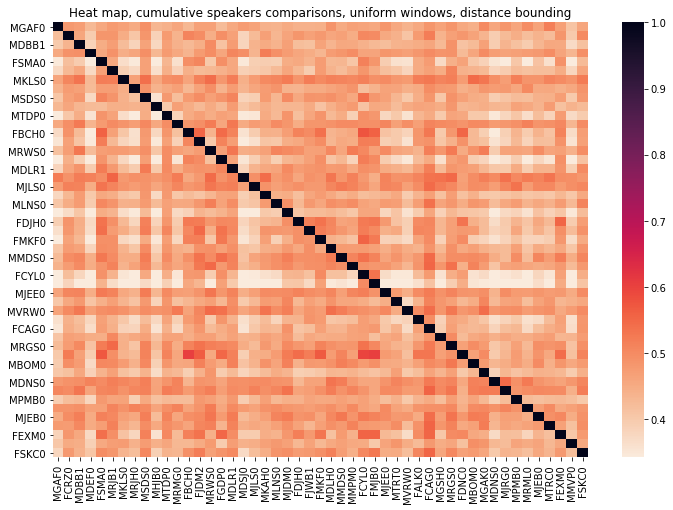

In [101]:
#transform df in shape I need
row_col = df_decisions.speaker_id_true.unique()
col_values = []
for row in row_col:
    row_values = []
    for col in row_col:
        row_values.append(df_decisions[(df_decisions.speaker_id_true == row) & 
            (df_decisions.speaker_id_test == col)].mean()['dec_50'])
    col_values.append(row_values)
df_heatmap = pd.DataFrame(col_values, index=row_col, columns=row_col)

plt.figure(figsize=(12, 8))
plt.title("Heat map, cumulative speakers comparisons, uniform windows, distance bounding")
sns.heatmap(df_heatmap, robust=True, cmap=sns.cm.rocket_r)

#save the figure for later
plt.savefig('experiment_data/exp1b_interspeaker_comp_' + run_name + '.png')

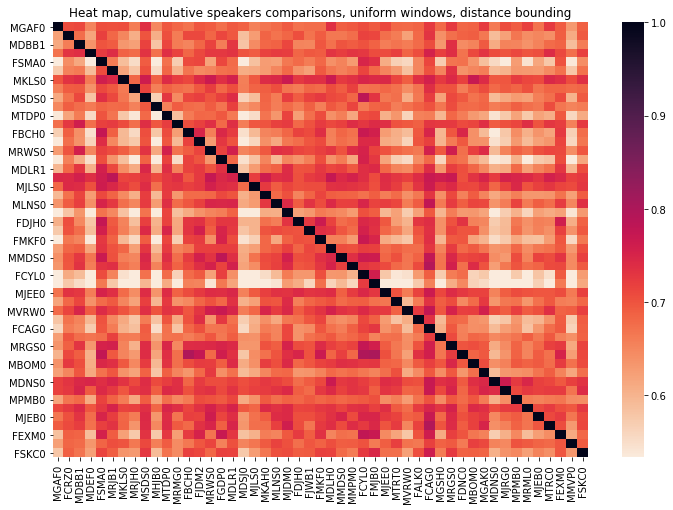

In [102]:
#transform df in shape I need
row_col = df_decisions.speaker_id_true.unique()
col_values = []
for row in row_col:
    row_values = []
    for col in row_col:
        row_values.append(df_decisions[(df_decisions.speaker_id_true == row) & 
            (df_decisions.speaker_id_test == col)]['dec_90'].mean())
    col_values.append(row_values)
df_heatmap = pd.DataFrame(col_values, index=row_col, columns=row_col)

plt.figure(figsize=(12, 8))
plt.title("Heat map, cumulative speakers comparisons, uniform windows, distance bounding")
sns.heatmap(df_heatmap, robust=True, cmap=sns.cm.rocket_r)

#save the figure for later
plt.savefig('experiment_data/exp1b_interspeaker_comp_' + run_name + '.png')

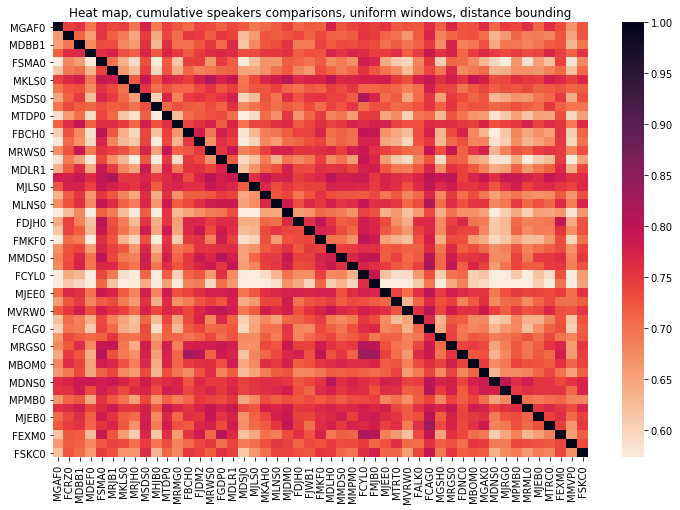

In [103]:
#transform df in shape I need
row_col = df_decisions.speaker_id_true.unique()
col_values = []
for row in row_col:
    row_values = []
    for col in row_col:
        row_values.append(df_decisions[(df_decisions.speaker_id_true == row) & 
            (df_decisions.speaker_id_test == col)]['dec_95'].mean())
    col_values.append(row_values)
df_heatmap = pd.DataFrame(col_values, index=row_col, columns=row_col)

plt.figure(figsize=(12, 8))
plt.title("Heat map, cumulative speakers comparisons, uniform windows, distance bounding")
sns.heatmap(df_heatmap, cmap=sns.cm.rocket_r, robust=True)

#save the figure for later
plt.savefig('experiment_data/exp1b_interspeaker_comp_' + run_name + '.png')

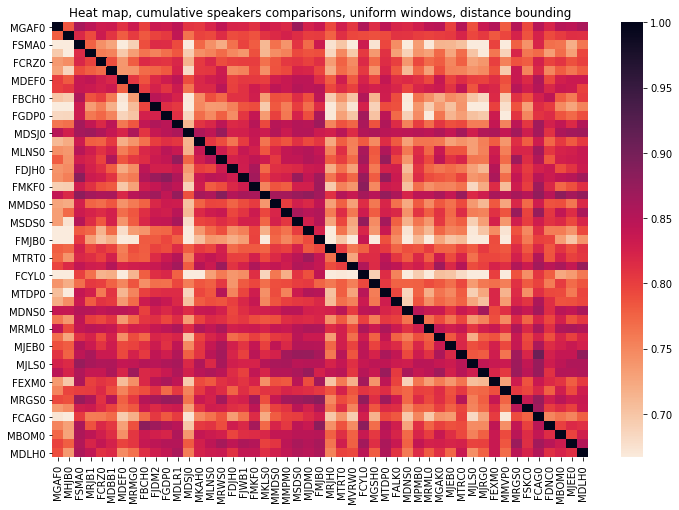

In [174]:
#transform df in shape I need
row_col = df_decisions.speaker_id_true.unique()
col_values = []
for row in row_col:
    row_values = []
    for col in row_col:
        row_values.append(df_decisions[(df_decisions.speaker_id_true == row) & 
            (df_decisions.speaker_id_test == col)]['dec_99'].mean())
    col_values.append(row_values)
df_heatmap = pd.DataFrame(col_values, index=row_col, columns=row_col)

plt.figure(figsize=(12, 8))
plt.title("Heat map, cumulative speakers comparisons, uniform windows, distance bounding")
sns.heatmap(df_heatmap, cmap=sns.cm.rocket_r, robust=True)

#save the figure for later
#plt.savefig('experiment_data/exp1b_interspeaker_comp_' + run_name + '.png')

In [173]:
plt.savefig('experiment_data/exp1b_interspeaker_99.png')

<Figure size 432x288 with 0 Axes>

In [176]:
fp_set = df_decisions[(df_decisions.speaker_id_true != df_decisions.speaker_id_test)].groupby(['speaker_id_true', \
                                                    'speaker_id_test']).agg('mean').reset_index()

for value in np.arange(0.8, 1.0, 0.01):
    print("FP rate k = ", value, ": ", fp_set[fp_set.dec_99 >= value].count()[0] / fp_set.count()[0])


FP rate k =  0.8 :  0.5361394557823129
FP rate k =  0.81 :  0.4604591836734694
FP rate k =  0.8200000000000001 :  0.36607142857142855
FP rate k =  0.8300000000000001 :  0.27508503401360546
FP rate k =  0.8400000000000001 :  0.18579931972789115
FP rate k =  0.8500000000000001 :  0.1096938775510204
FP rate k =  0.8600000000000001 :  0.04974489795918367
FP rate k =  0.8700000000000001 :  0.0195578231292517
FP rate k =  0.8800000000000001 :  0.00510204081632653
FP rate k =  0.8900000000000001 :  0.00042517006802721087
FP rate k =  0.9000000000000001 :  0.00042517006802721087
FP rate k =  0.9100000000000001 :  0.0
FP rate k =  0.9200000000000002 :  0.0
FP rate k =  0.9300000000000002 :  0.0
FP rate k =  0.9400000000000002 :  0.0
FP rate k =  0.9500000000000002 :  0.0
FP rate k =  0.9600000000000002 :  0.0
FP rate k =  0.9700000000000002 :  0.0
FP rate k =  0.9800000000000002 :  0.0
FP rate k =  0.9900000000000002 :  0.0


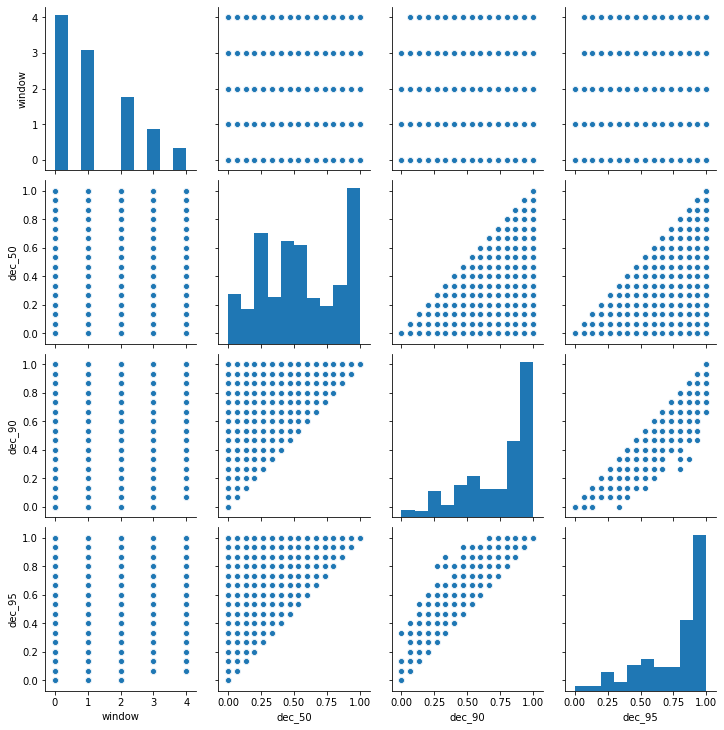

In [17]:
sns.pairplot(df_decisions[df_decisions['window'] < 5][['window', 'dec_50', 'dec_90', 'dec_95']])

In [51]:
df_decisions['baseline'] = df_decisions.apply(lambda row: True if row['speaker_id_test'] ==\
                row['speaker_id_true'] else False, axis=1)
df_bigram_analysis = df_decisions[df_decisions['window'] < 5][['speaker_id_true', 'speaker_id_test', \
                'window', 'bigram', 'baseline', 'dec_50', 'dec_90', 'dec_95']].groupby(['speaker_id_true', \
                                                        'speaker_id_test', 'baseline', \
                                                        'bigram']).agg('mean').reset_index()

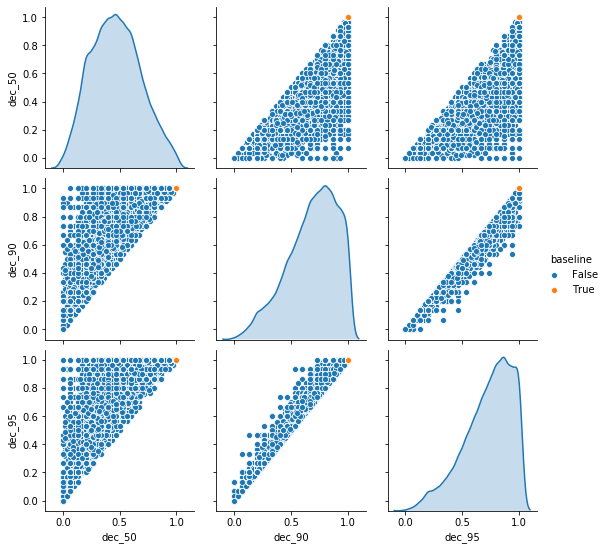

In [52]:
sns.pairplot(df_bigram_analysis[['baseline', 'bigram', 'dec_50', 'dec_90', 'dec_95']], hue="baseline")

In [53]:
df_bigram_analysis

speaker_id_true speaker_id_test  baseline    bigram  window  dec_50  \
0               FALK0           FALK0      True   aɪ -- n     2.0     1.0   
1               FALK0           FALK0      True  aɪ -- t̚     2.0     1.0   
2               FALK0           FALK0      True    b -- ɹ     0.5     1.0   
3               FALK0           FALK0      True   dʒ -- ɨ     0.5     1.0   
4               FALK0           FALK0      True  d̚ -- dʒ     1.0     1.0   
...               ...             ...       ...       ...     ...     ...   
20278           MVRW0           MVRW0      True   ɨ -- b̚     0.5     1.0   
20279           MVRW0           MVRW0      True    ʃ -- ɝ     2.0     1.0   
20280           MVRW0           MVRW0      True    ʉ -- z     1.5     1.0   
20281           MVRW0           MVRW0      True   ʌ -- k̚     2.0     1.0   
20282           MVRW0           MVRW0      True    ʌ -- n     1.0     1.0   

       dec_90  dec_95  
0         1.0     1.0  
1         1.0     1.0  
2         1.0     1.0  
3         1.0     1.0  
4         1.0     1.0  
...       ...     ...  
20278     1.0     1.0  
20279     1.0     1.0  
20280     1.0     1.0  
20281     1.0     1.0  
20282     1.0     1.0  

[20283 rows x 8 columns]

In [78]:
worst = []
for key, group in df_bigram_analysis.groupby('speaker_id_true'):
    worst.append(group.sort_values(by='dec_50').head(int(len(df_bigram_analysis.bigram.unique()) * .50)))

In [79]:
tmp_a = worst[0]
tmp_b = worst[1]

tmp_c = tmp_a.merge(tmp_b, left_on=['bigram'], right_on=['bigram']\
           , suffixes=('_left', '_right'))

In [80]:
print(tmp_a.bigram.unique())
print(tmp_b.bigram.unique())
print(tmp_c.bigram.unique())

['ɨ -- n' 's -- k̚' 'k̚ -- k' 'ð -- i' 'ʃ -- n̩' 'd̚ -- dʒ' 'dʒ -- ɨ'
 'ʌ -- n' 's -- ʌ' 'ʃ -- ɪ' 'k̚ -- s' 'ɪ -- m' 'eɪ -- ʃ' 't̚ -- t'
 'm -- æ' 'ɨ -- m' 'ɾ -- i' 'ɹ -- eɪ' 'i -- z' 'ʃ -- ɨ' 'ʃ -- aɪ'
 'eɪ -- d̚' 'n -- z' 'ɹ -- ɾ' 'k -- ɚ' 'b -- ɹ' 'ɹ -- aɪ' 'ɚ -- ɹ'
 'ɑ -- ɹ' 'ɝ -- z' 'n -- ʃ' 'æ -- s' 'æ -- d̚' 'p -- ɑ' 'n -- eɪ'
 'aɪ -- t̚' 'w -- ʌ' 'æ -- k̚' 'aɪ -- n' 'oʊ -- ʃ' 'ɔ -- n' 'm -- ɝ'
 't -- æ' 'j -- oʊ']
['t̚ -- t' 'd̚ -- dʒ' 'k̚ -- k' 'p̚ -- p' 'ɨ -- d̚' 'd -- ɨ' 'd̚ -- d'
 't -- ə̥' 'ɡ̚ -- ɡ' 'n -- t̚' 'ɹ -- ɛ' 'k -- ɝ' 'ɝ -- s' 'ɨ -- n'
 'ʔ -- æ' 'ɝ -- ɨ' 'ɪ -- k̚' 'ɾ -- ɨ' 'ʉ -- d̚' 'ɨ -- k̚' 'j -- ʉ'
 'i -- z' 'l -- oʊ' 'l -- i' 'æ -- k̚' 'k -- ɨ' 't -- i' 'p -- l' 'ɛ -- l'
 'm -- ʌ' 'æ -- p̚' 't -- ʉ' 'aʊ -- ɾ' 'oʊ -- m' 'j -- ɚ' 'ɨ -- p̚'
 'ɡ -- ɛ' 'm -- ɪ']
['ɨ -- n' 'k̚ -- k' 'd̚ -- dʒ' 't̚ -- t' 'i -- z' 'æ -- k̚']


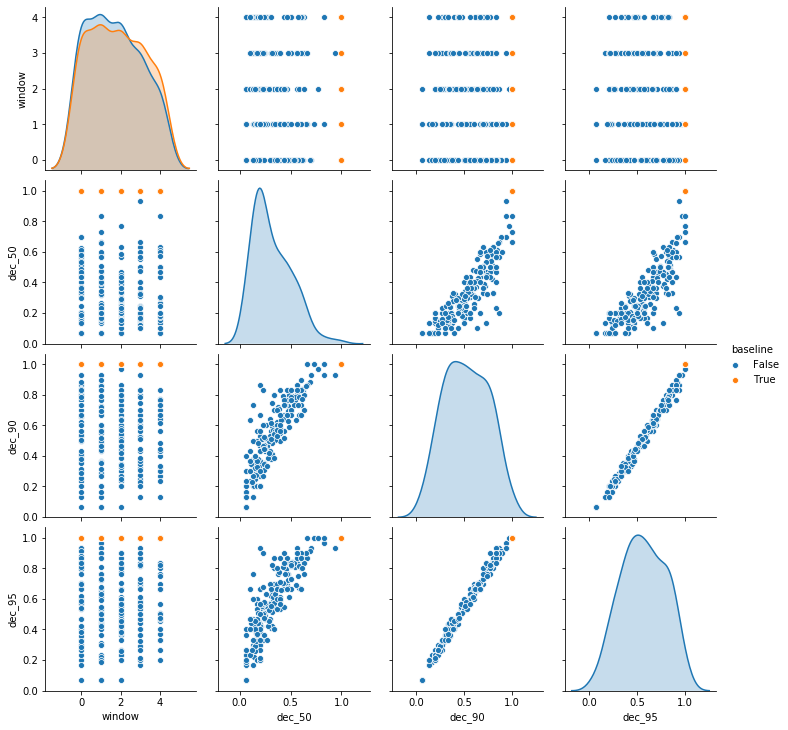

In [21]:
#sort by decision value, find the bigrams most vulnerable
worst_bigrams = df_bigram_analysis.sort_values(by='dec_50').head(int(\
                        len(df_bigram_analysis.bigram.unique()) * .10))['bigram'].values
sns.pairplot(df_bigram_analysis[df_bigram_analysis.bigram.isin(worst_bigrams)]\
             [['window', 'baseline', 'bigram', 'dec_50', 'dec_90', 'dec_95']], hue="baseline")

In [22]:
df_tmp = df_decisions[(df_decisions['window'] < 5)][['speaker_id_test', \
                'window', 'bigram', 'baseline', 'dec_50', 'dec_90', 'dec_95']].groupby(['window', \
                'baseline', 'bigram', 'speaker_id_test']).agg('mean').reset_index()
df_tmp

window  baseline    bigram speaker_id_test    dec_50    dec_90  \
0           0     False  aɪ -- b̚           MKLS0  0.300000  0.733333   
1           0     False  aɪ -- b̚           MRJH0  0.533333  0.766667   
2           0     False  aɪ -- b̚           MSDS0  0.566667  0.866667   
3           0     False  aɪ -- d̚           MDLH0  0.533333  0.733333   
4           0     False  aɪ -- d̚           MRJH0  0.333333  0.733333   
...       ...       ...       ...             ...       ...       ...   
15579       4      True    θ -- ɨ           FCAG0  1.000000  1.000000   
15580       4      True    θ -- ɪ           FSMA0  1.000000  1.000000   
15581       4      True    θ -- ɪ           MRJB1  1.000000  1.000000   
15582       4      True    θ -- ɪ           MRMG0  1.000000  1.000000   
15583       4      True    θ -- ɹ           FSKC0  1.000000  1.000000   

         dec_95  
0      0.733333  
1      0.833333  
2      0.866667  
3      0.800000  
4      0.733333  
...         ...  
15579  1.000000  
15580  1.000000  
15581  1.000000  
15582  1.000000  
15583  1.000000  

[15584 rows x 7 columns]

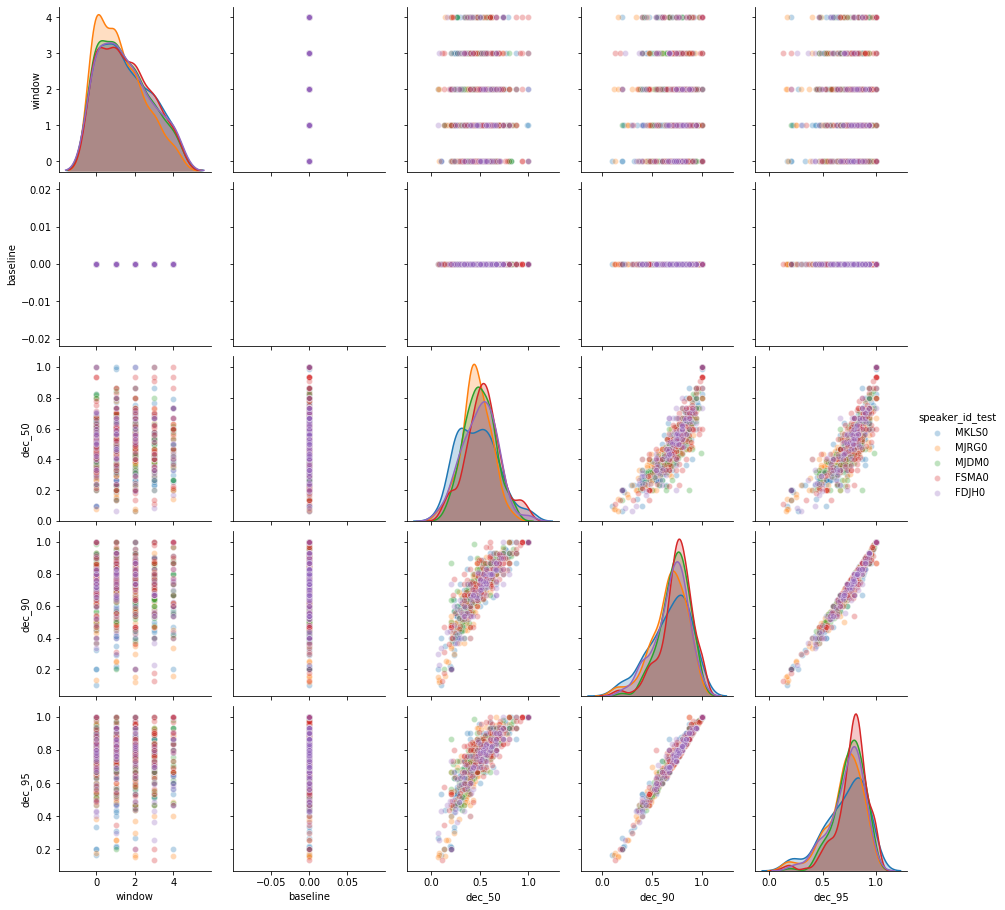

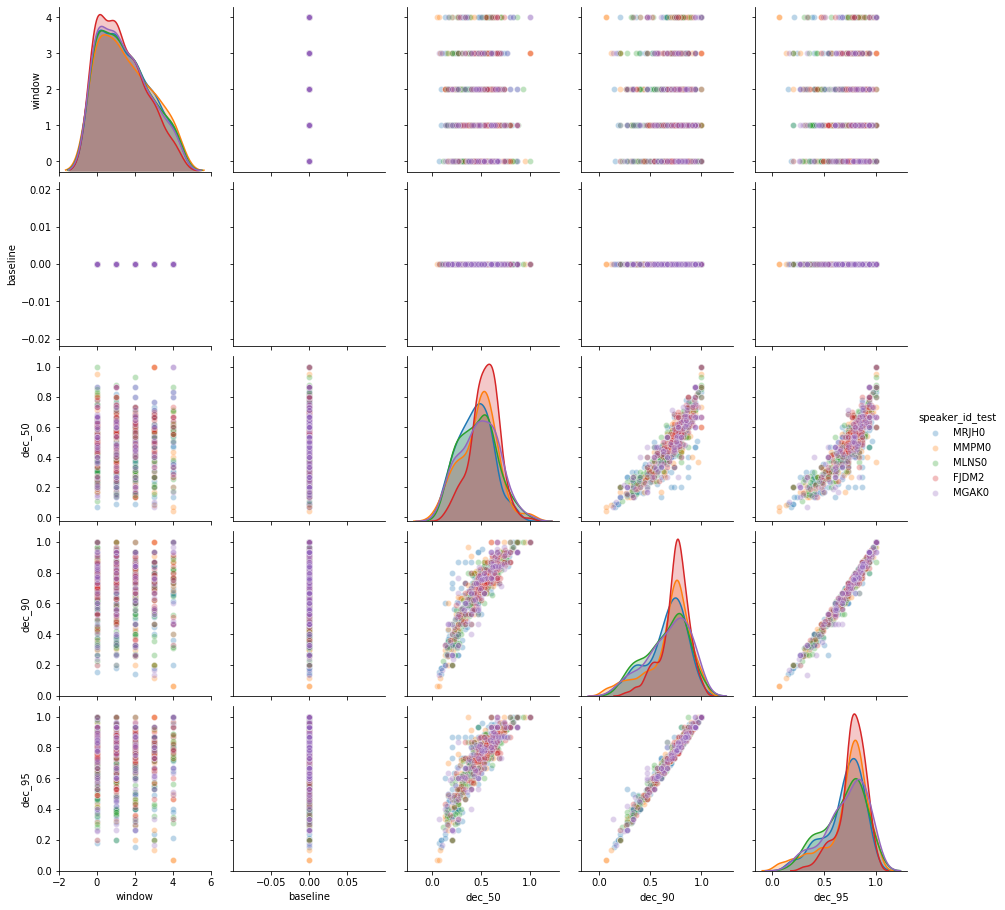

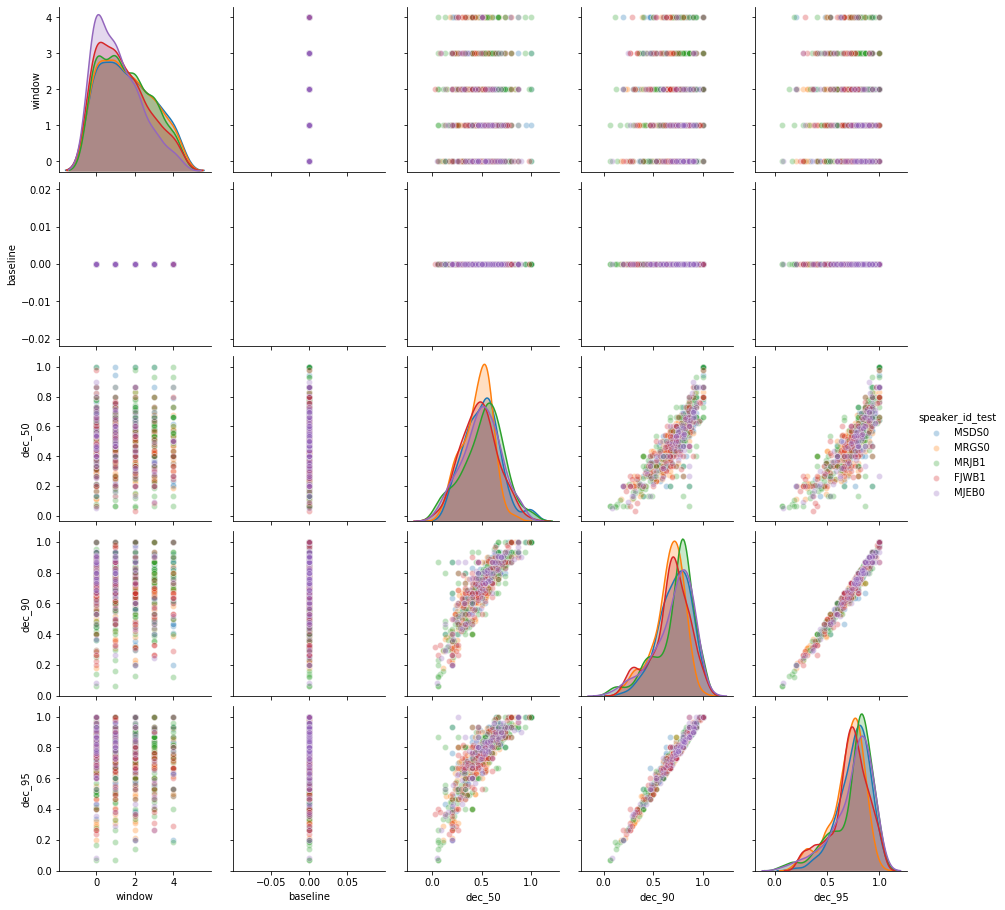

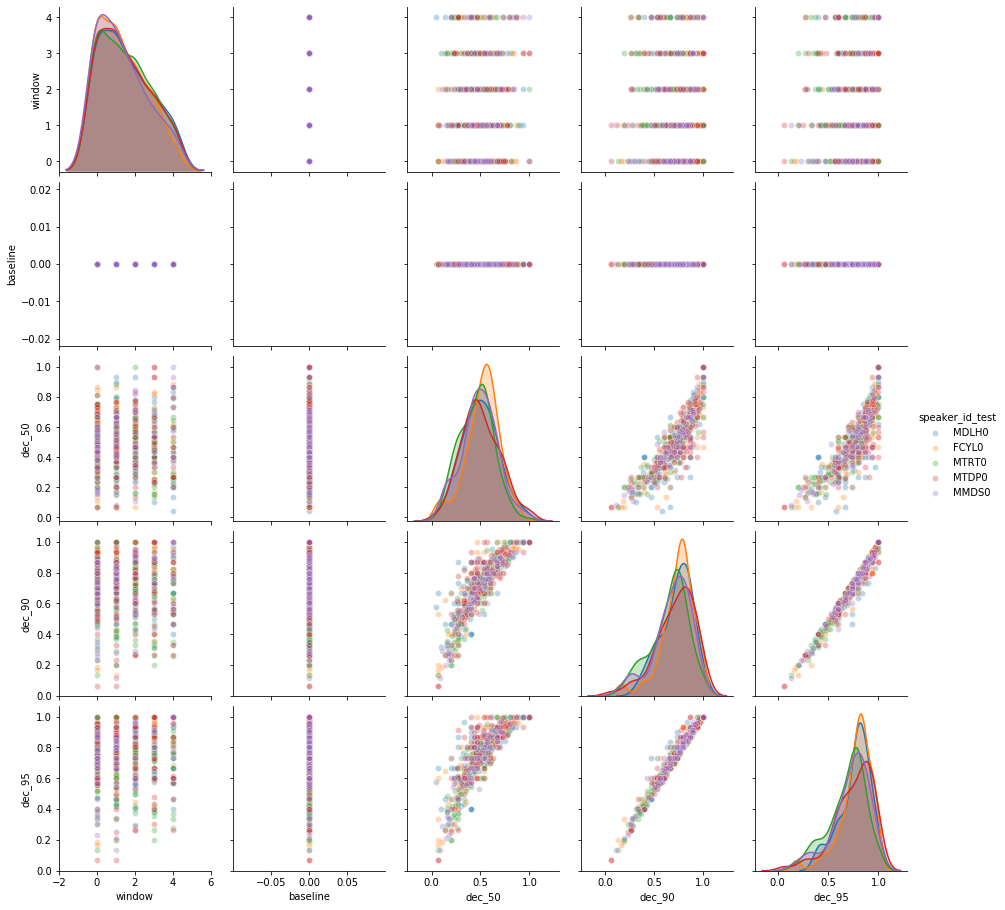

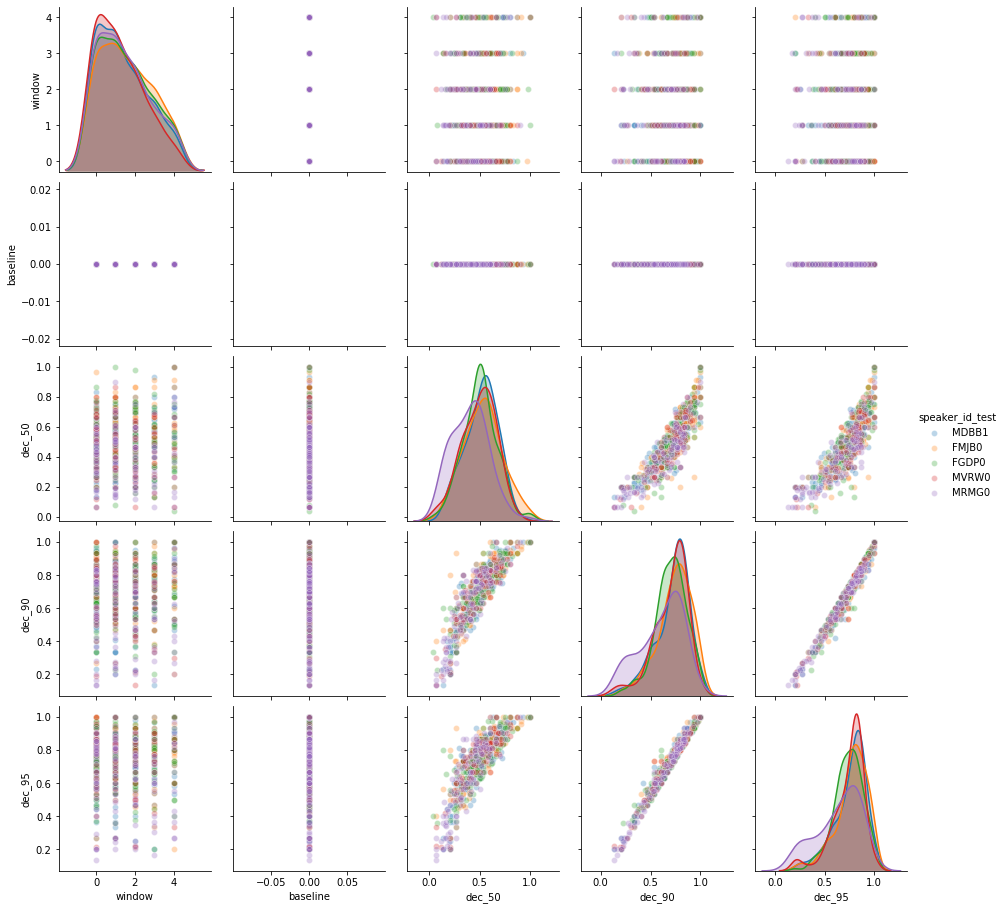

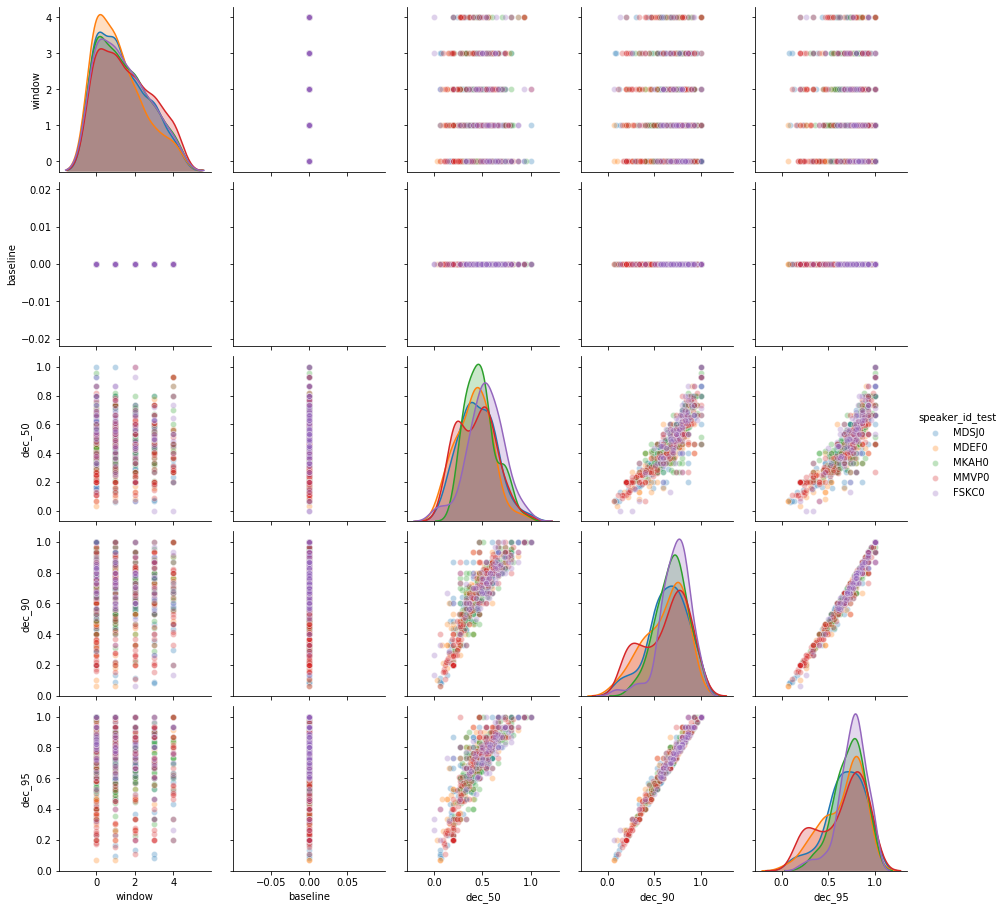

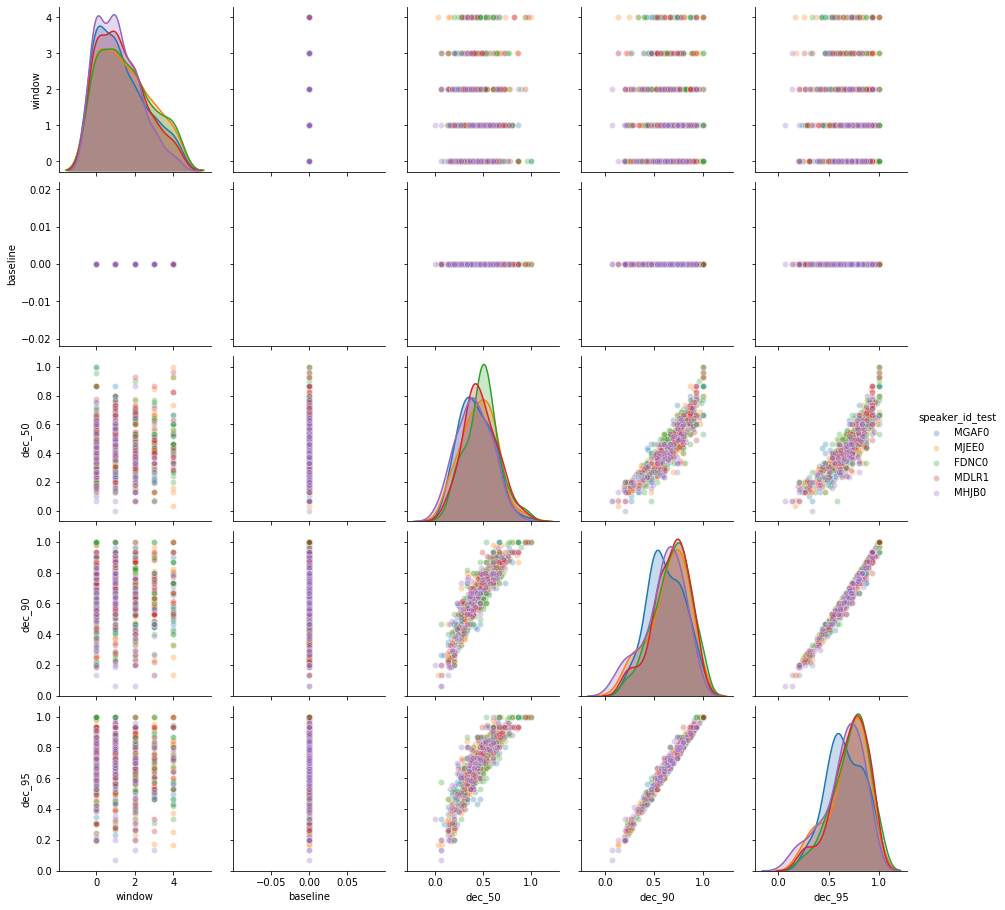

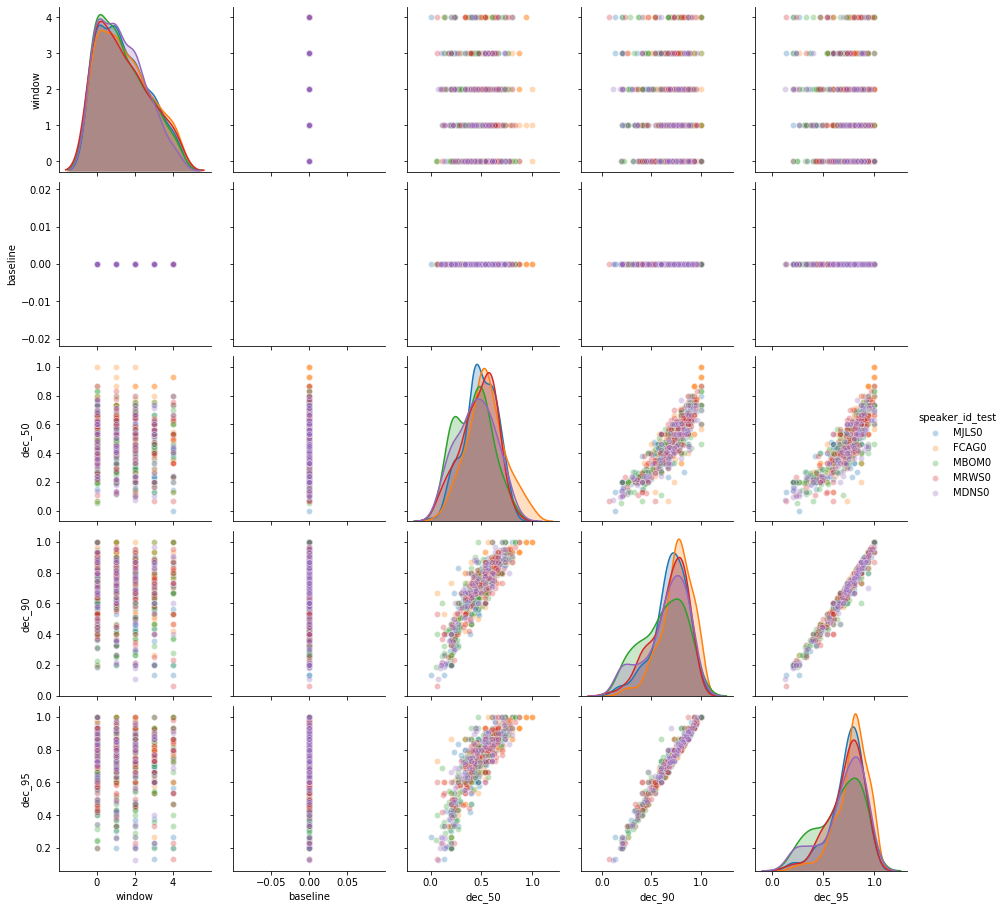

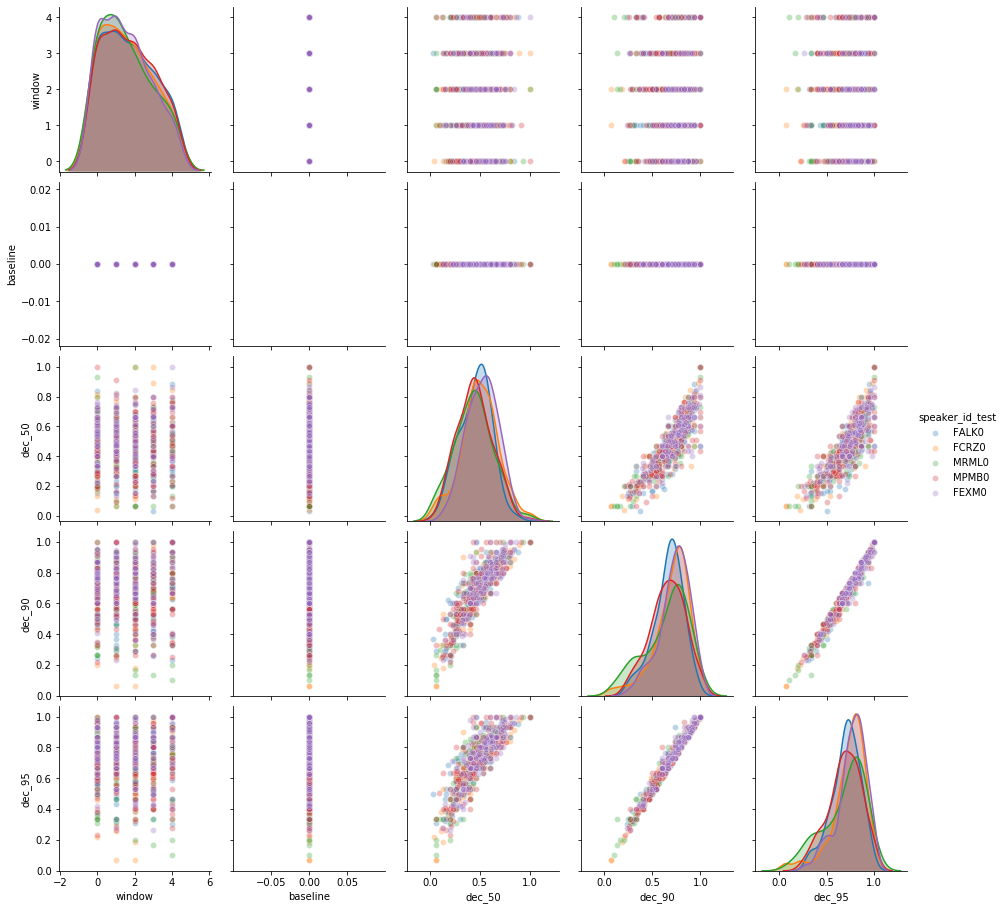

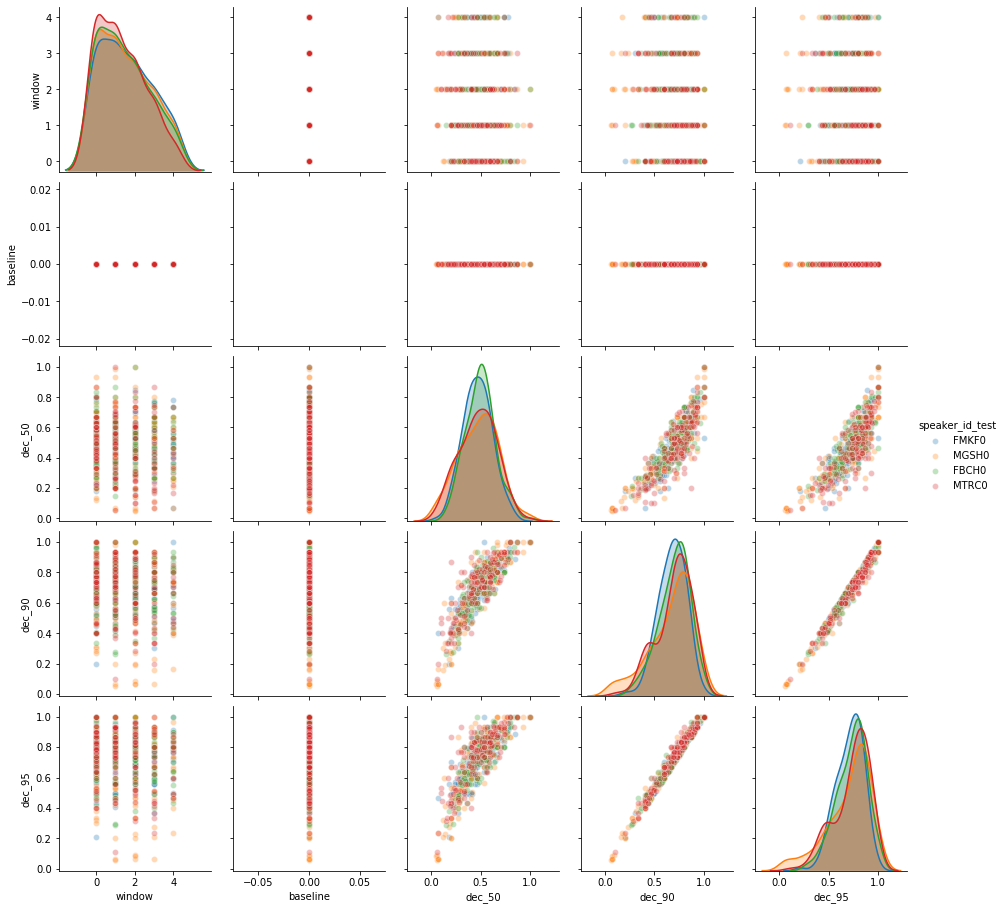

In [23]:
uniq_speakers = df_tmp.speaker_id_test.unique()
for i in range(0, 10):
    sns.pairplot(df_tmp[(df_tmp.speaker_id_test.isin(uniq_speakers[i::10])) & (df_tmp.baseline==False)],\
                hue="speaker_id_test", diag_kind='kde', plot_kws={'alpha':0.3})
    plt.show()

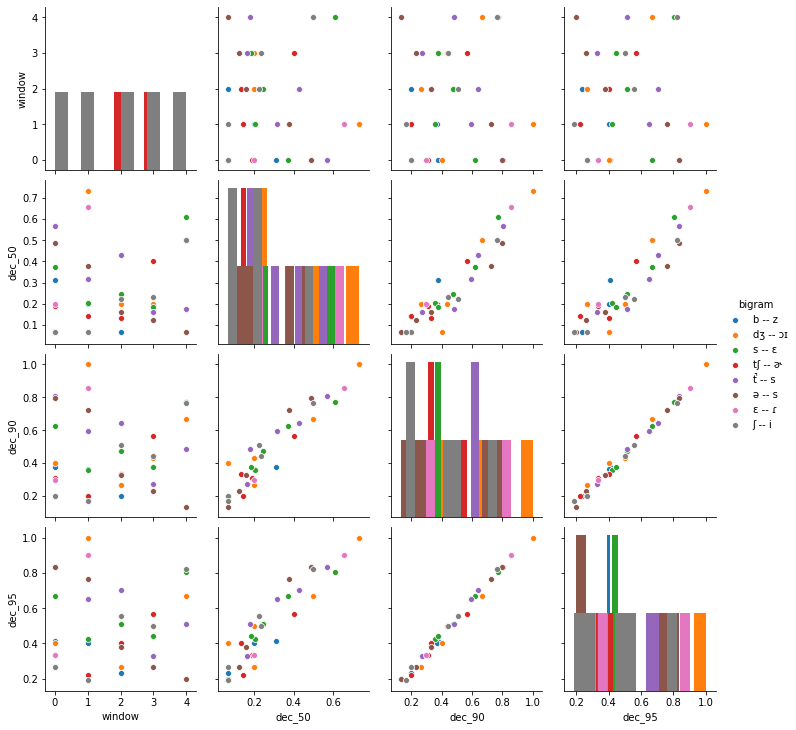

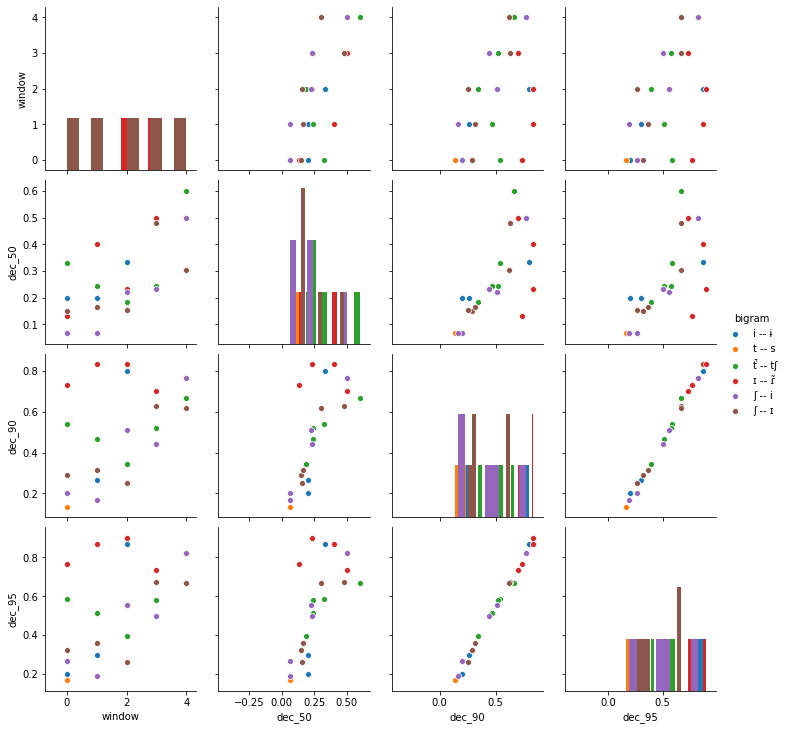

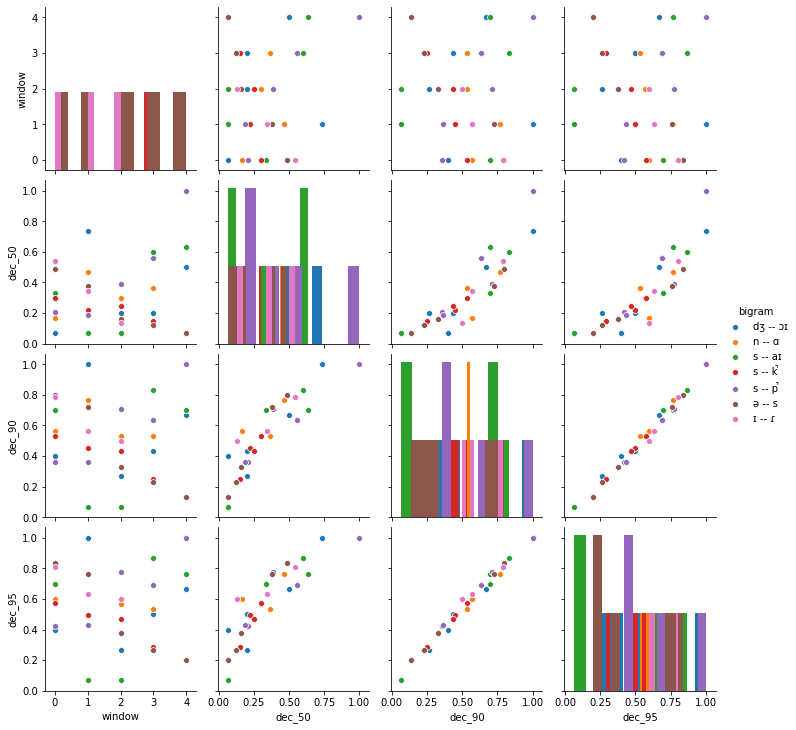

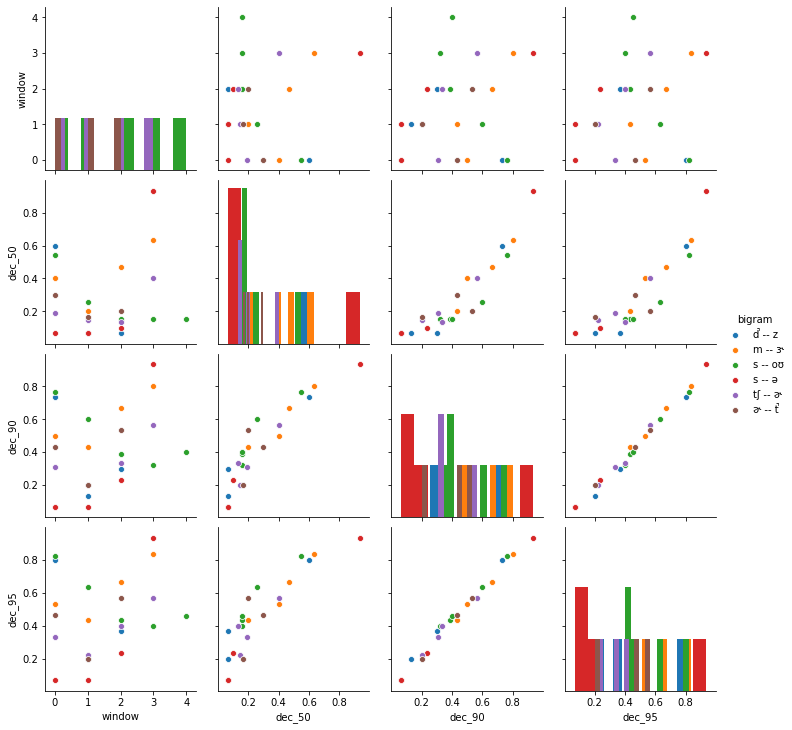

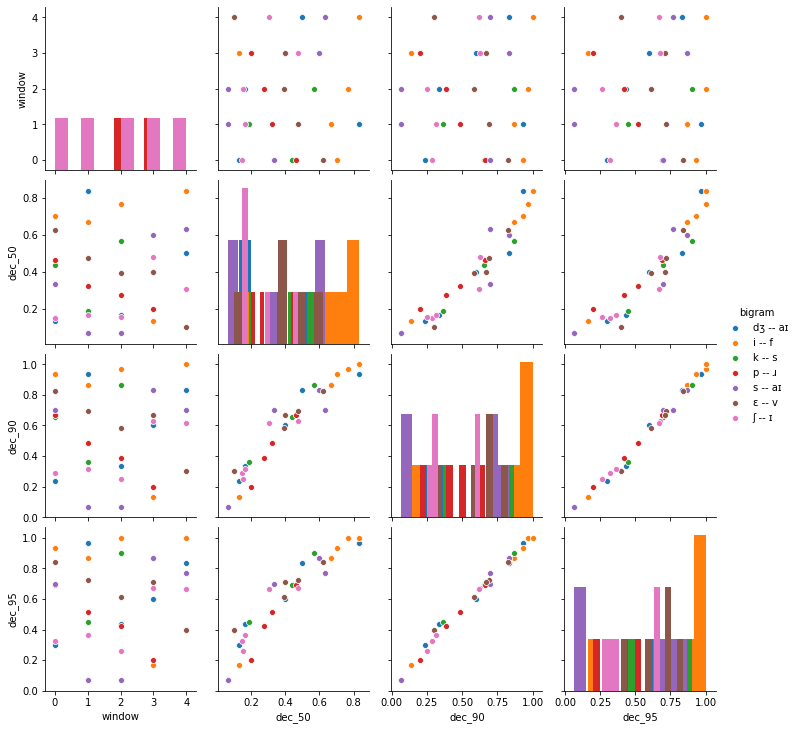

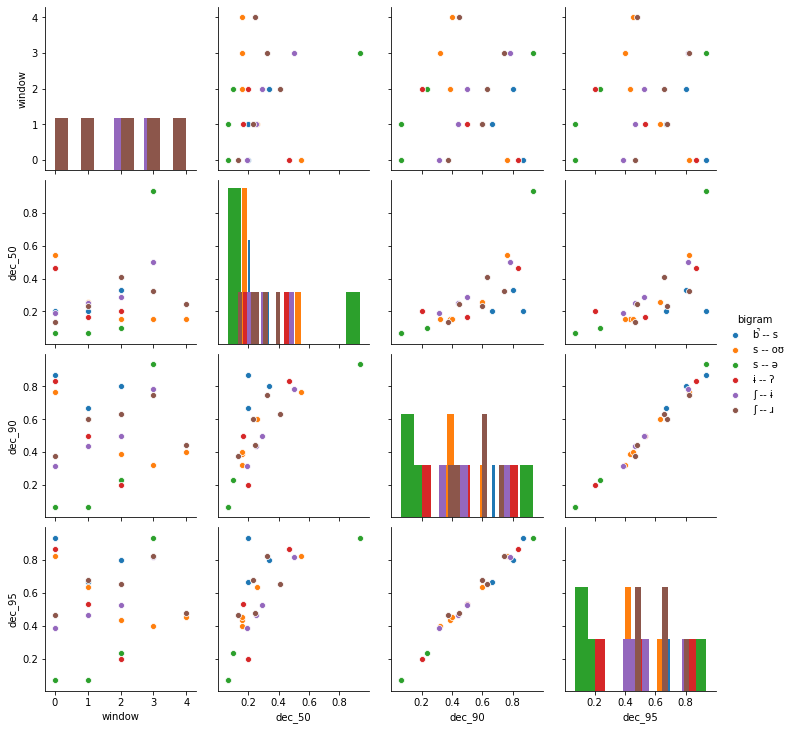

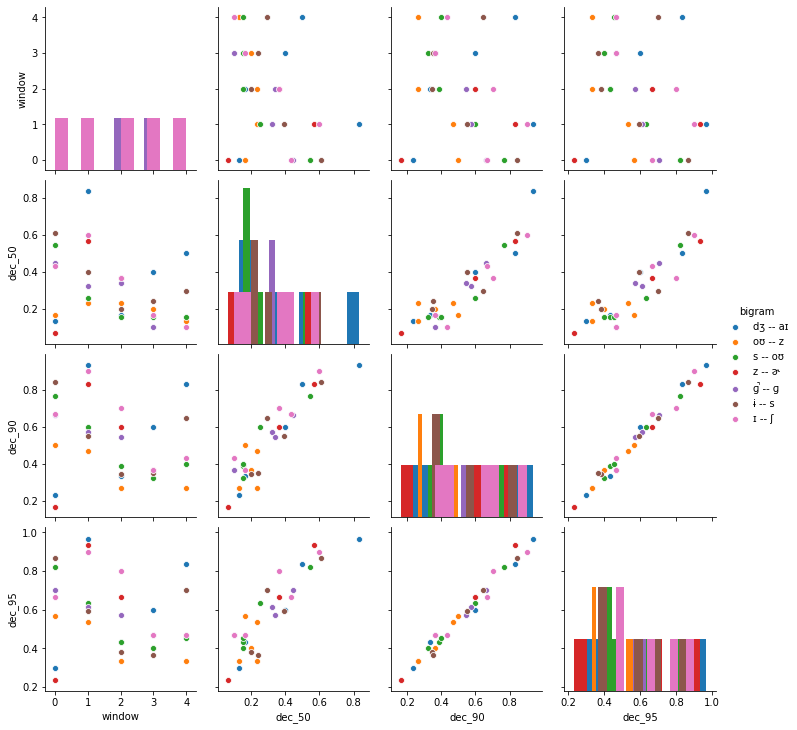

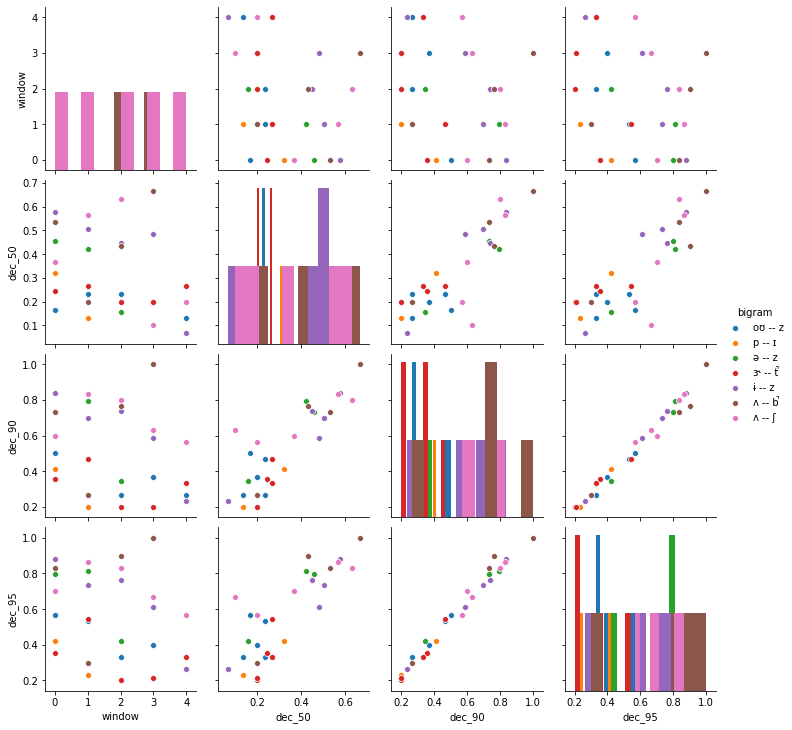

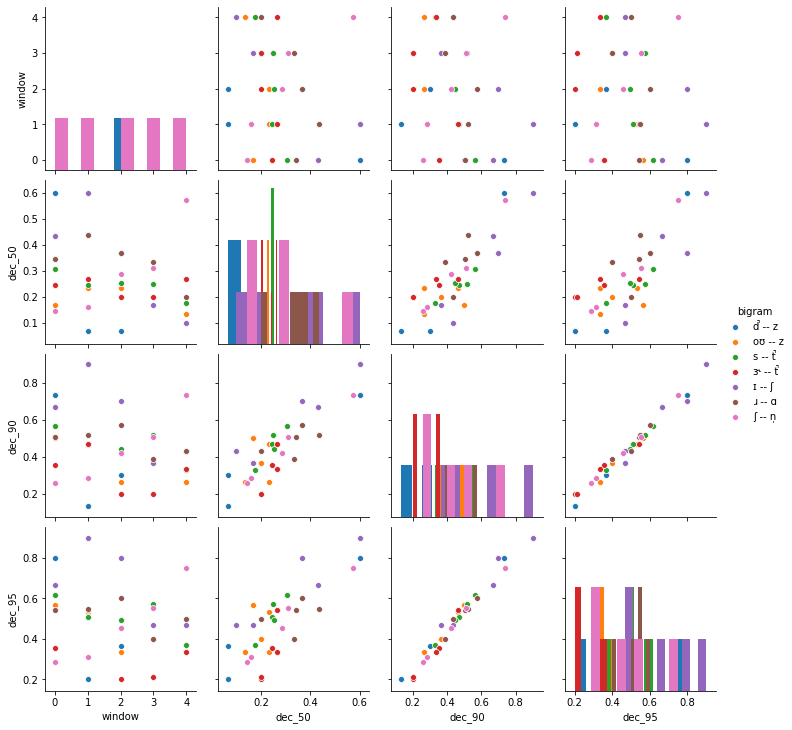

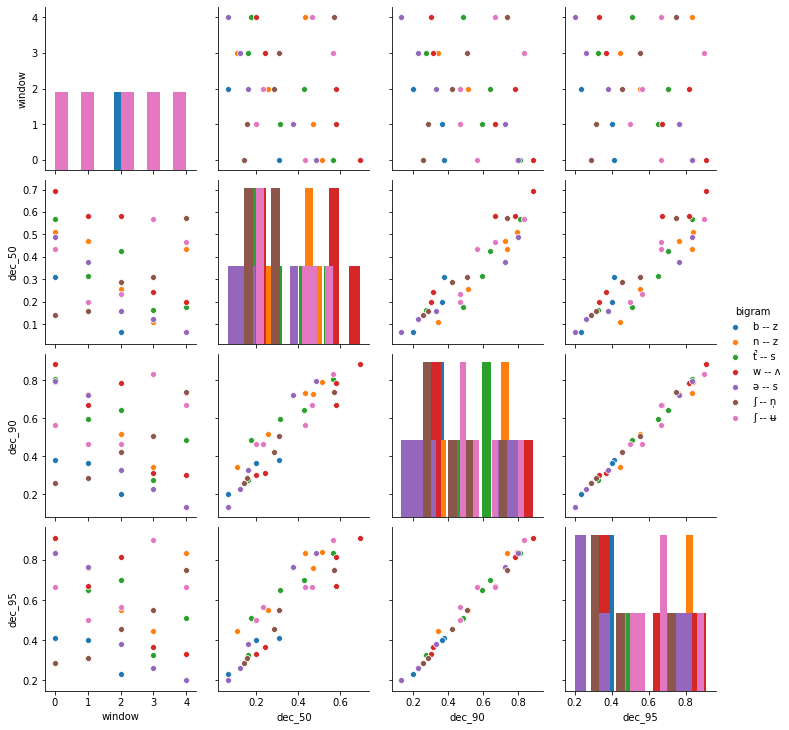

In [24]:
#do only 10 bigrams at a time
for i in range(0, 10): 
    sns.pairplot(df_bigram_analysis[(df_bigram_analysis.bigram.isin(worst_bigrams[i::10])) & 
                                   (df_bigram_analysis.baseline==False)]\
             [['window', 'bigram', 'dec_50', 'dec_90', 'dec_95']], hue="bigram", diag_kind='hist')
    plt.plot()

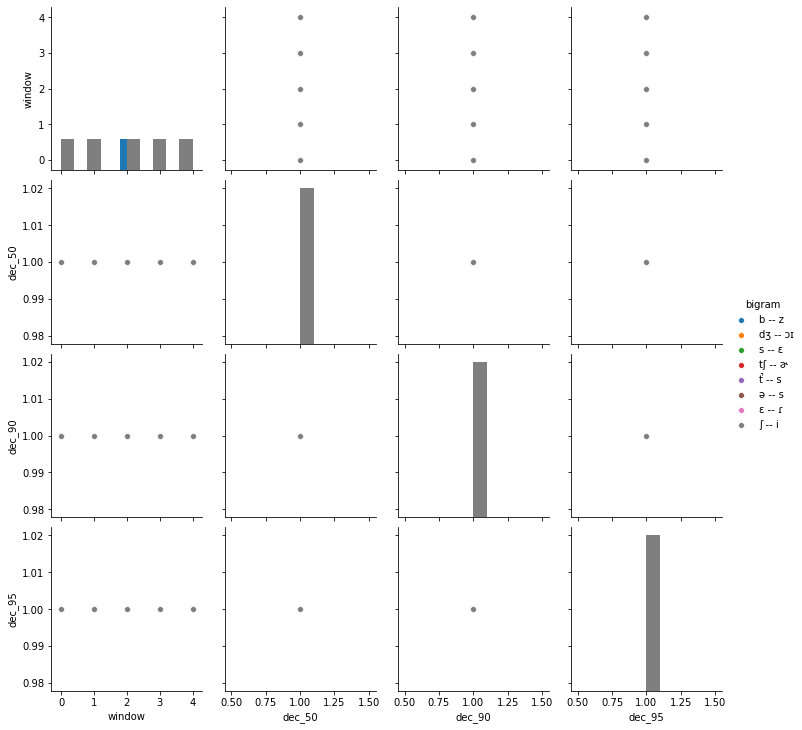

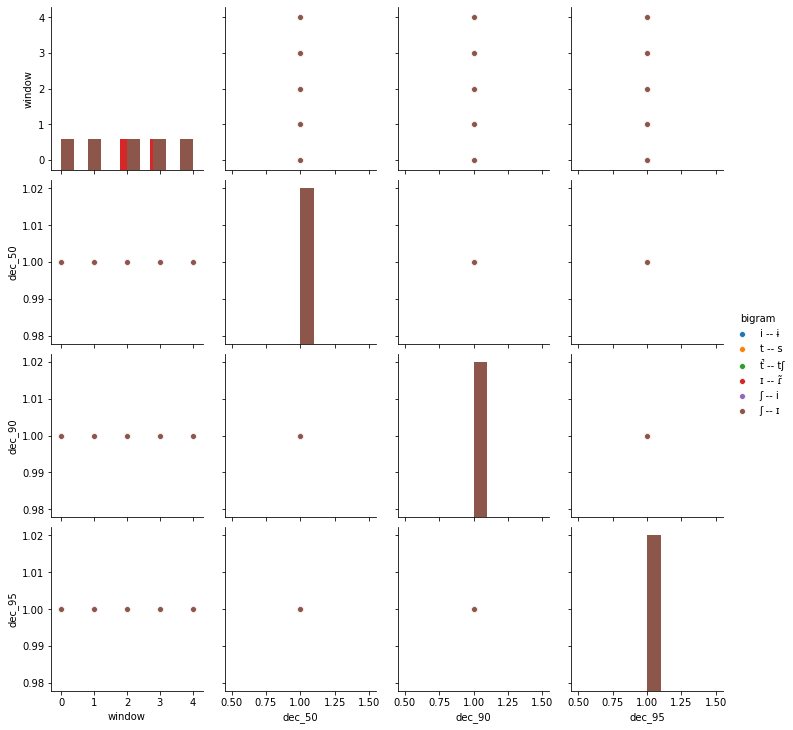

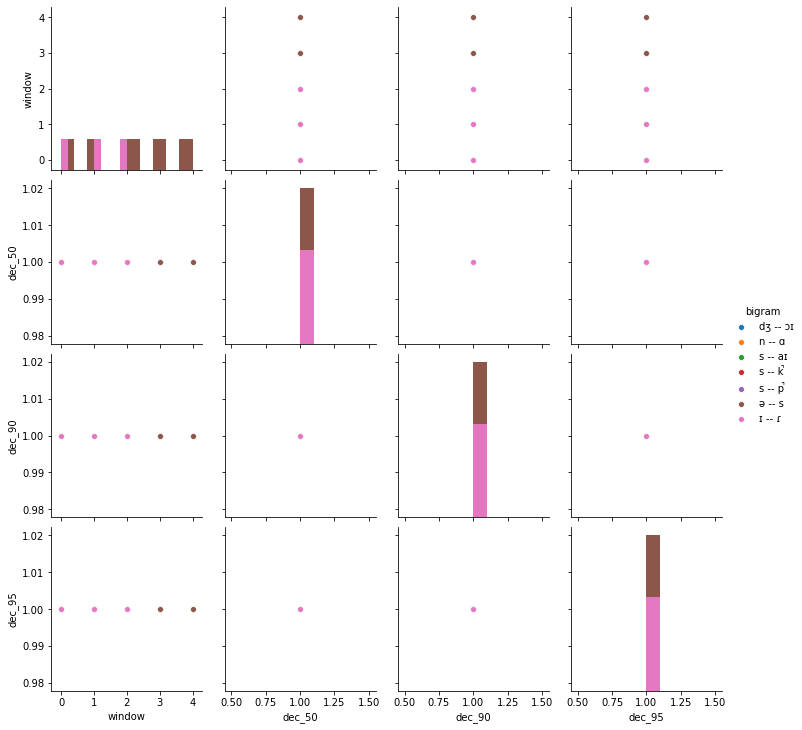

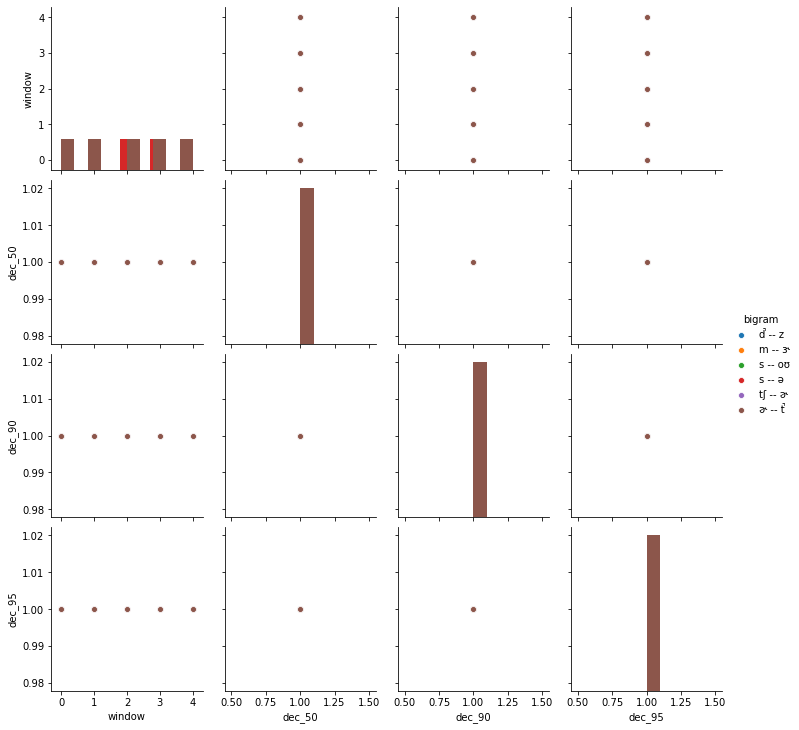

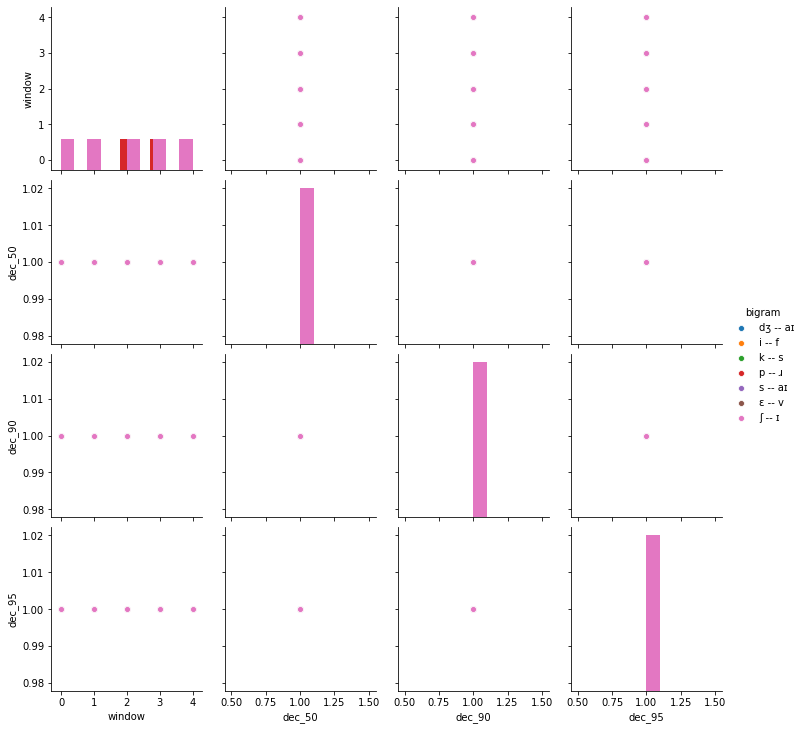

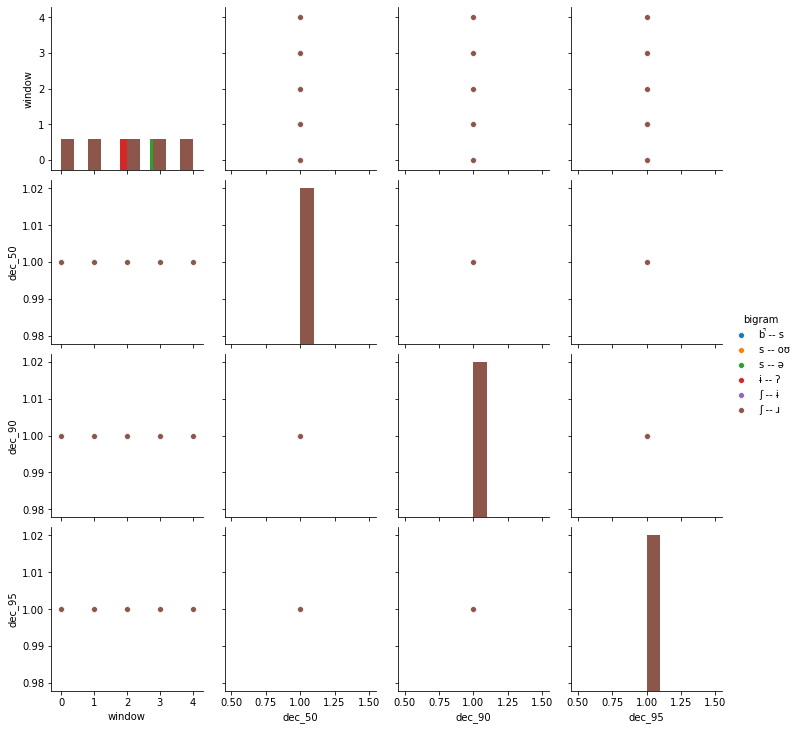

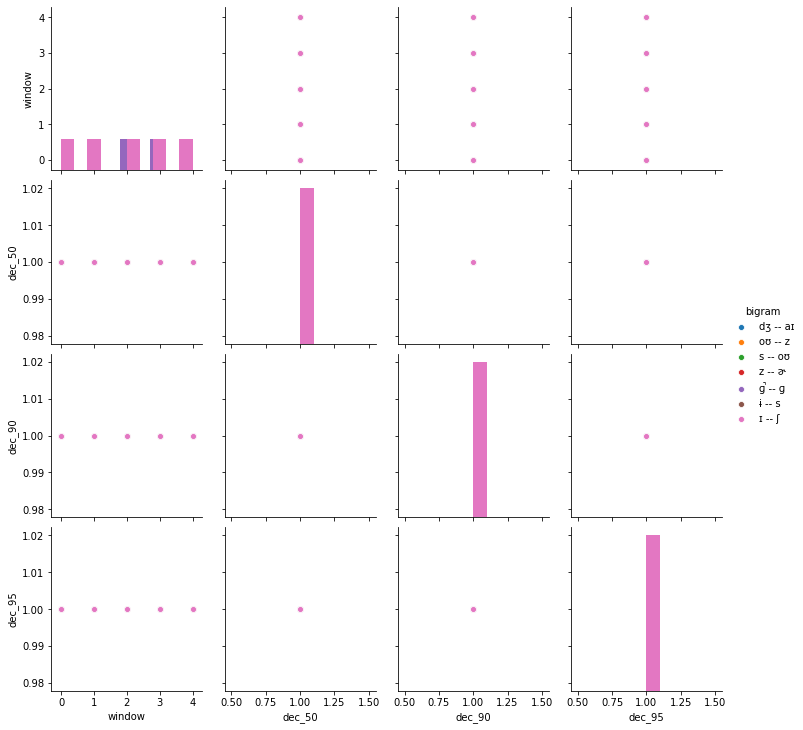

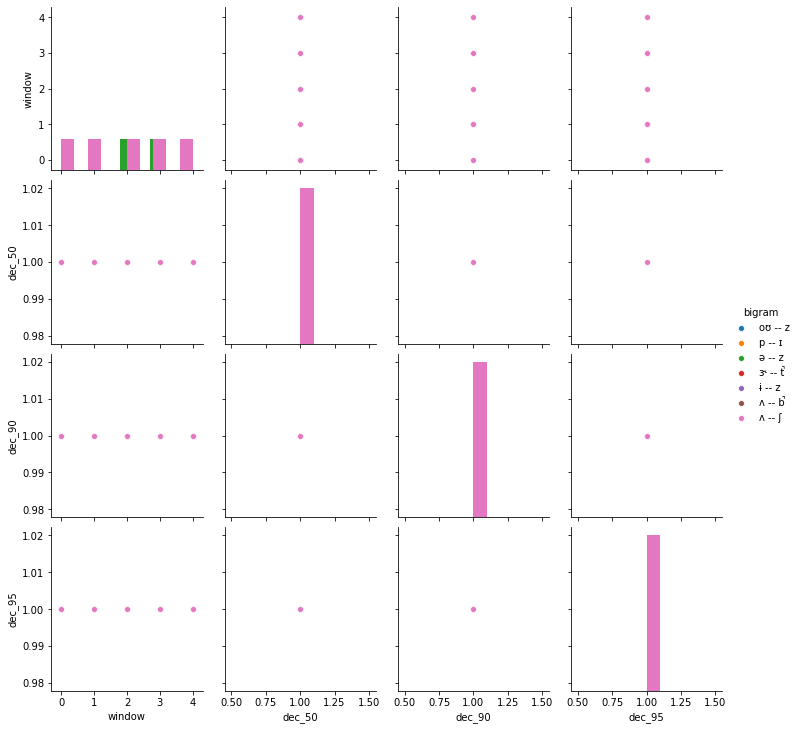

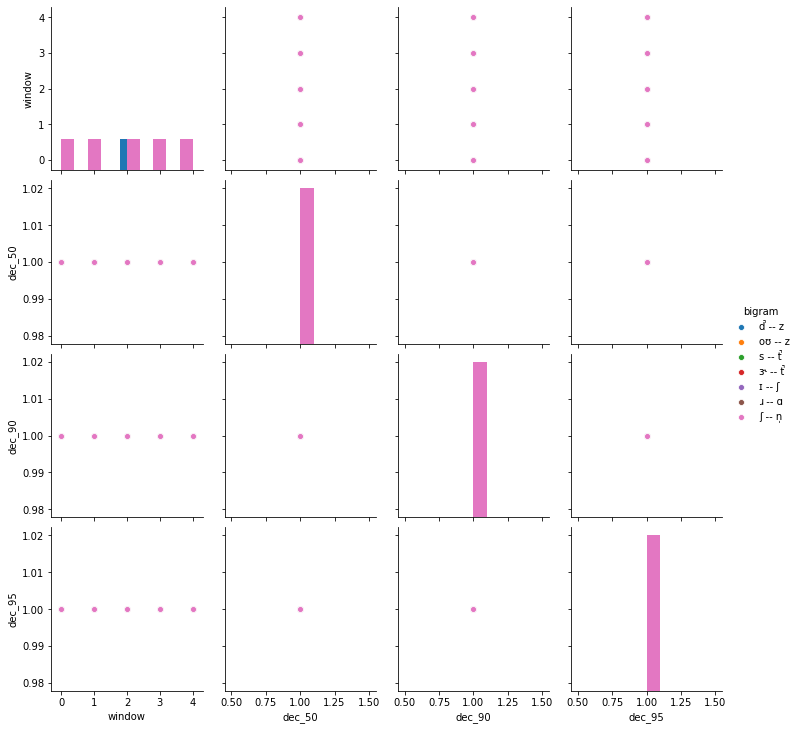

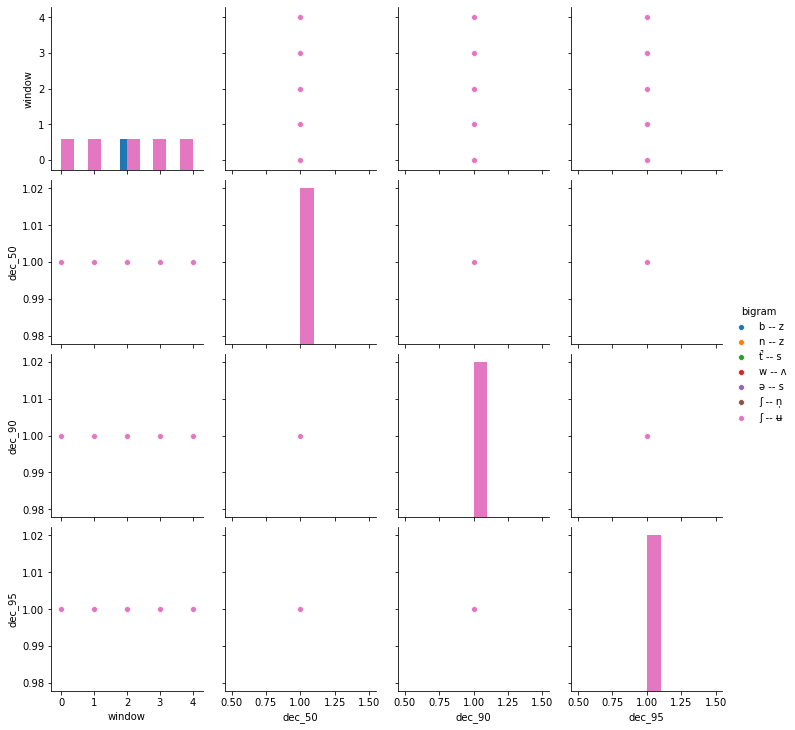

In [25]:
#do only 10 bigrams at a time
for i in range(0, 10): 
    sns.pairplot(df_bigram_analysis[(df_bigram_analysis.bigram.isin(worst_bigrams[i::10])) & 
                                   (df_bigram_analysis.baseline==True)]\
             [['window', 'bigram', 'dec_50', 'dec_90', 'dec_95']], hue="bigram", diag_kind='hist')
    plt.plot()

In [310]:
df_bigram_analysis

window  baseline    bigram    dec_50    dec_90    dec_95
0          0     False  aɪ -- b̚  0.409910  0.454955  0.495495
1          0     False  aɪ -- d̚  0.408067  0.572482  0.604627
2          0     False   aɪ -- f  0.513514  0.666667  0.698198
3          0     False   aɪ -- i  0.391892  0.567568  0.567568
4          0     False   aɪ -- j  0.324324  0.391892  0.432432
...      ...       ...       ...       ...       ...       ...
8889       4      True    θ -- ɚ  1.000000  1.000000  1.000000
8890       4      True    θ -- ɝ  1.000000  1.000000  1.000000
8891       4      True    θ -- ɨ  1.000000  1.000000  1.000000
8892       4      True    θ -- ɪ  1.000000  1.000000  1.000000
8893       4      True    θ -- ɹ  1.000000  1.000000  1.000000

[8894 rows x 6 columns]

### Note on the above result
While this result looks great, I think we are still dealing with having a poor testing methodology for the baseline test. I'm trying to think of a better testing mechanism b/c currently I think we are artificially fixing our true values at 1.0 unfairly. This is because we are using the statistically distance for 50% of the estimated distribution will be exact matchs in the dec_50 graph, 90% in dec_90, and 95% in the dec_95 graph. 

Interestingly, the windowing information suggests that once again the largest deviations from the true values come from durning shorter bigrams. This could be b/c speech on the whole is very predictable so we need to look for very minor differences. 

Additionally, I find it interesting that our dec_50 test has such a hard division at 0.5. This implies that all these bigrams **fail at every dimension for every window**, which is a bit strange tbh. 

In [26]:
df_worst = df_decisions[df_decisions.bigram.isin(worst_bigrams)].groupby([\
                'speaker_id_test', 'speaker_id_true', 'bigram']).agg('mean').reset_index()
df_worst = df_worst.groupby(['speaker_id_test', 'speaker_id_true']).agg('mean').reset_index()


In [39]:
df_worst.groupby(['speaker_id_true']).agg('count')

speaker_id_test  index  window  dec_50  dec_90  dec_95  \
speaker_id_true                                                           
FALK0                         20     20      20      20      20      20   
FBCH0                         25     25      25      25      25      25   
FCAG0                         16     16      16      16      16      16   
FCRZ0                         23     23      23      23      23      23   
FCYL0                         29     29      29      29      29      29   
FDJH0                         30     30      30      30      30      30   
FDNC0                          2      2       2       2       2       2   
FEXM0                         41     41      41      41      41      41   
FGDP0                         37     37      37      37      37      37   
FJDM2                         33     33      33      33      33      33   
FJWB1                         28     28      28      28      28      28   
FMJB0                         27     27      27      27      27      27   
FMKF0                         25     25      25      25      25      25   
FSKC0                         26     26      26      26      26      26   
FSMA0                         38     38      38      38      38      38   
MBOM0                         34     34      34      34      34      34   
MDBB1                         34     34      34      34      34      34   
MDEF0                         22     22      22      22      22      22   
MDLH0                         38     38      38      38      38      38   
MDLR1                         44     44      44      44      44      44   
MDNS0                         41     41      41      41      41      41   
MDSJ0                         39     39      39      39      39      39   
MGAF0                         45     45      45      45      45      45   
MGAK0                         37     37      37      37      37      37   
MGSH0                         40     40      40      40      40      40   
MHJB0                         30     30      30      30      30      30   
MJDM0                         36     36      36      36      36      36   
MJEB0                         21     21      21      21      21      21   
MJEE0                         38     38      38      38      38      38   
MJLS0                         34     34      34      34      34      34   
MJRG0                         30     30      30      30      30      30   
MKAH0                         37     37      37      37      37      37   
MKLS0                         22     22      22      22      22      22   
MLNS0                         35     35      35      35      35      35   
MMDS0                         29     29      29      29      29      29   
MMPM0                         29     29      29      29      29      29   
MMVP0                         35     35      35      35      35      35   
MPMB0                         32     32      32      32      32      32   
MRGS0                         18     18      18      18      18      18   
MRJB1                         42     42      42      42      42      42   
MRJH0                         40     40      40      40      40      40   
MRMG0                         38     38      38      38      38      38   
MRML0                          4      4       4       4       4       4   
MRWS0                         35     35      35      35      35      35   
MSDS0                         25     25      25      25      25      25   
MTDP0                         28     28      28      28      28      28   
MTRC0                         34     34      34      34      34      34   
MTRT0                         41     41      41      41      41      41   
MVRW0                          8      8       8       8       8       8   

                 baseline  
speaker_id_true            
FALK0                  20  
FBCH0                  25  
FCAG0                  16  
FCRZ0                  23  
FCYL0                  

In [27]:
#Using only the worst bigrams, compare speakers
#transform df in shape I need
df_worst = df_decisions[df_decisions.bigram.isin(worst_bigrams)].groupby([\
                'speaker_id_test', 'speaker_id_true', 'bigram']).agg('mean').reset_index()
df_worst = df_worst.groupby(['speaker_id_test', 'speaker_id_true']).agg('mean').reset_index()
row_col = df_worst.speaker_id_true.unique()

#50
col_values = []
for row in row_col:
    row_values = []
    for col in row_col:
        row_values.append(df_worst[(df_worst.speaker_id_true == row) & 
            (df_worst.speaker_id_test == col)]['dec_50'].values[0])
    col_values.append(row_values)
df_heatmap = pd.DataFrame(col_values, index=row_col, columns=row_col)

plt.figure(figsize=(30, 24))
plt.title("Heat map, cumulative speakers comparisons, uniform windows, distance bounding")
sns.heatmap(df_heatmap, robust=True, cmap=sns.cm.rocket_r, annot=True)
plt.show()

#90
col_values = []
for row in row_col:
    row_values = []
    for col in row_col:
        row_values.append(df_worst[(df_worst.speaker_id_true == row) & 
            (df_worst.speaker_id_test == col)]['dec_90'].values[0])
    col_values.append(row_values)
df_heatmap = pd.DataFrame(col_values, index=row_col, columns=row_col)

plt.figure(figsize=(30, 24))
plt.title("Heat map, cumulative speakers comparisons, uniform windows, distance bounding")
sns.heatmap(df_heatmap, robust=True, cmap=sns.cm.rocket_r, annot=True)
plt.show()

#95
col_values = []
for row in row_col:
    row_values = []
    for col in row_col:
        row_values.append(df_worst[(df_worst.speaker_id_true == row) & 
            (df_worst.speaker_id_test == col)]['dec_95'].values[0])
    col_values.append(row_values)
df_heatmap = pd.DataFrame(col_values, index=row_col, columns=row_col)

plt.figure(figsize=(30, 24))
plt.title("Heat map, cumulative speakers comparisons, uniform windows, distance bounding")
sns.heatmap(df_heatmap, robust=True, cmap=sns.cm.rocket_r, annot=True)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

## Experiment 2b
Visualize how unique a bigram compared to all other bigrams spoken by a speaker, run across all speakers. 
Will probably need to check average variability within a bigram for each bigram 
(i.e., we need to have a baseline to compare against, so conduct a similar analysis for subsets of the samples
we have for each bigram [set(a,b,c,d) -> ks_test(set[:3], set[3])]). 

Run on Timit Dataset

### Functions

In [182]:
threshold = 0.3
def decision(row):
    if row['test_outter_prob'] > threshold:
        ans = 1
    else:
        ans = 0
    return ans

#z score comparison calculation and probability calculation
def comparison(row):
    if row['distro_acc_stdev_true'] == -1:
        #We have to use the speaker's average stdev
        z_score = abs((row['distro_mu_test'] - row['distro_mu_true']) / row['ave_stdev_true'])
    else:
        #use the bigram specific stdev
        z_score = abs((row['distro_mu_test'] - row['distro_mu_true']) / row['distro_acc_stdev_true'])
    
    #Outter norm probability
    outter_prob = 1 - stats.norm.cdf(z_score)
    
    return z_score, outter_prob

#comparison full step, decorate the df with all new additional information
#this is a wrapper around the actual functions doing the comparison
def compare_wrapper(df_test):
    #calculate z score for every row test
    z_col = []
    prob_col = []
    for index, row in df_test.iterrows():
        ans_z, ans_prob = comparison(row)
        z_col.append(ans_z)
        prob_col.append(ans_prob)

    df_test['z_score'] = z_col
    df_test['test_outter_prob'] = prob_col

    #probability calculation
    #df_test['decision'] = df_test.apply(decision, axis=1)
    #TODO: For now, we will simply operate off the outter prob value, and apply the decision later in
    #process (this would be decision on individual dimensions)
    df_test['decision'] = prob_col
    
    #return new decorated df
    return df_test

### Main experiment run

In [ ]:
limited_columns = ['label', 'window', 'dimension', 'distro_mu', 'distro_acc_stdev', \
                   'ave_stdev']

def compare_process_exp2(inputs):
    key_speaker, speaker_group = inputs
    #within bigram, groupby speaker
    bigram_groups = speaker_group.groupby('label')
    bigram_decisions = []
    for key_bigram, bigram_group in bigram_groups: 
        #other speakers comparison (outter compare)
        other_bigrams = bigram_group
        #merge true and test rows and then calculate the comparison in df
        df_test = bigram_group.merge(other_bigrams[limited_columns], \
                                      left_on=['window', 'dimension'], \
                                      right_on=['window', 'dimension'], \
                                      suffixes=('_true', '_test'))
        df_test = compare_wrapper(df_test)
        
        """
        comparison is now complete for every window/dimension, now we need to aggregate everything 
        in a final value for each bigram.
        
        For now we will do this aggregation by averaging the decision values for all dimensinos per
        window, and then averaging the decision value for all windows per single bigram. Then, we will
        do one final averaging for all bigrams. This wil  give us the value to plot/judge. 
        """
        win_ave = df_test.groupby(['label_test', 'window'])\
                                                        [['decision']].agg('mean').reset_index()
        bigram_ave = win_ave.groupby('label_test')[['decision']].agg('mean')
        bigram_ave['label_true'] = key_bigram
        bigram_decisions.append(bigram_ave.reset_index())
        
    bigram_dec = pd.concat(bigram_decisions, ignore_index=True)
    bigram_dec['speaker_id'] = key_speaker
    #bigram_decisions.append(bigram_dec)      
    return bigram_dec

#groupby bigrams
speaker_groups = area_distros.groupby('speaker_id')
speaker_decisions = []
#for key_bigram, bigram_group in tqdm(bigram_groups):
with Pool(4) as p:
    for x in tqdm(p.imap_unordered(compare_process_exp2, speaker_group, 
                  total=len(speaker_group)):
        speaker_decisions.append(x)
    
df_decisions = pd.concat(speaker_decisions, ignore_index=True)
df_decisions =  df_decisions.groupby(['label_test', 'label_true']).agg('mean')
df_decisions = df_decisions.reset_index()

### Graph Output

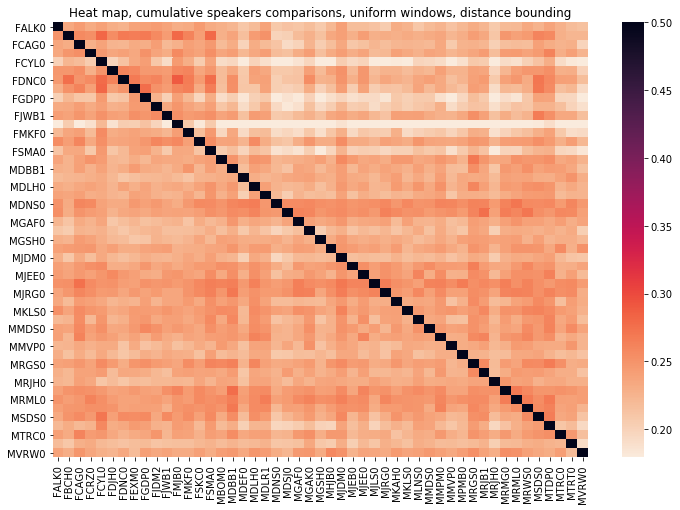

In [181]:
#transfomr df in shape I need
row_col = df_decisions.speaker_id_true.unique()
col_values = []
for row in row_col:
    row_values = []
    for col in row_col:
        row_values.append(df_decisions[(df_decisions.speaker_id_true == row) & 
                    (df_decisions.speaker_id_test == col)]['decision'].values[0])
    col_values.append(row_values)
df_heatmap = pd.DataFrame(col_values, index=row_col, columns=row_col)

plt.figure(figsize=(12, 8))
plt.title("Heat map, cumulative speakers comparisons, uniform windows, distance bounding")
sns.heatmap(df_heatmap, robust=True, cmap=sns.cm.rocket_r)

#save the figure for later
plt.savefig('experiment_data/exp1b_interspeaker_comp_' + run_name + '.png')

# Experiment 03
Conduct our analysis of deepfaked audio
* real time mode
* lyrebird
* ASV Spoof


## Functions for this experiment

In [37]:
def convert_unix(path):
    root_research = '/home/logan/drive/'
    return root_research + path.replace('\\', '/')[path.find('Research'):]

In [102]:
#prep functions
"""To simplify our manual labeling we will simple sweep through a labeled word in the fake audio process (the 
fake acoustic core runs) searching for bigram we know should be in that word for that speakers. So that means we 
to augment the both dataset with word labels.

--> How do we handle one window overlapping 2 words...? (Ans: If at least half of window in word, we will treat it as 
                        being a part of that word.)
"""
#augment deepfake processed data with word labels
def add_words(df):
    fake_files = df.groupby(['filepath'])
    df_aug = []
    for key, grp in fake_files:
        #read associated WRD file
        tmp = convert_unix(key)
        df_wrds = pd.read_csv(tmp[:-3] + 'WRD', delimiter=' ', header=None, names=['start', 'end', 'word'])

        word_assignments = []
        #assign words to rows of the grp
        for _, row in grp.iterrows():
            #get middle div
            divide = (row.window_end - row.window_start) / 2 + row.window_start
            word = df_wrds[(df_wrds.start < divide) & (df_wrds.end > divide)]['word'].values
            if len(word) > 0:
                word = word[0]
            else:
                word = None
            word_assignments.append(word)
        grp['word'] = word_assignments 
        df_aug.append(grp)
    return pd.concat(df_aug, ignore_index=True)


"""===============Augment data=====================
Function to augment/manipulate the data from the acoustic core 
in order to allow for the area distributions to be analyzed properly
"""
def augment(input_vals):
    #set up
    key, index_area = input_vals
    area_distros = pd.DataFrame(columns=['speaker_id', 'sex', 'label', 'window', \
                                         'dimension', 'distro', 'word'])
    
    #get the area curves separately
    area_curves = index_area['cross_sect_est'].to_list()
    area_per_dim = list(zip(*area_curves))
    
    #add to new working df
    tmp = index_area['cross_sect_est'].tolist()
    tmp = list(zip(*tmp))
    new_row = {}
    new_row['speaker_id'] = index_area['speaker_id'].values[0]
    new_row['sex'] = index_area['sex'].values[0]
    new_row['label'] = index_area['label'].values[0]
    new_row['window'] = int(index_area['window_index'].values[0])
    new_row['word'] = index_area['word'].values[0]
    for index in range(0, len(tmp)):
        new_row['dimension'] = index
        new_row['distro'] = list(tmp[index])
        area_distros = area_distros.append(new_row, ignore_index=True)
    return area_distros

#augment the fake data to have each of the dimensions of the 
#hyper-dimensional space be it's own row
def augment_wrapper(df, name):
    key_columns = ['speaker_id', 'sex', 'label', 'window_index', 'word']
    df = add_words(df)
    grouped_df = df.groupby(key_columns)
    distros_list = []

    with Pool(4) as p:
        for x in tqdm(p.imap_unordered(augment, grouped_df), total=len(grouped_df), desc=name):
            distros_list.append(x)
    area_distros = pd.concat(distros_list)
    return area_distros


### Loading Data

In [20]:
#connect to mongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["exploration"]

#=========Real Time test===================
#move timit train over to df
try:
    data_csv = 'timit_train_augmented.csv'
    df_timit_train = pd.read_csv('experiment_data/' + data_csv)
    df_timit_train['distro'] = df_timit_train['distro'].apply(literal_eval)
    df_timit_train['dataset'] = 'true'
    print("Successfullying loaded ", data_csv)
except FileNotFoundError:
    data_name = 'timit_train_16'
    print("No csv found, loading from mongodb and reaugmenting: ", data_name)
    table = db[data_name]
    cursor = table.find()
    df_timit_train = pd.DataFrame(list(cursor))
    df_timit_train = df_timit_train.drop(columns='_id')
    #augment process
    df_timit_train = augment_wrapper(df_timit_train, data_name)
    df_timit_train['dataset'] = 'true'
    df_timit_train.to_csv('experiment_data/timit_train_augmented.csv', index=False)
    
#move real_time over to df
try:
    data_csv = 'real_time_fake_augmented.csv'
    df_rtf = pd.read_csv('experiment_data/' + data_csv)
    df_rtf['distro'] = df_rtf['distro'].apply(literal_eval)
    df_rtf['dataset'] = 'fake'
    print("Successfullying loaded ", data_csv)
except FileNotFoundError:
    data_name = 'real_time_fake_16'
    print("No csv found, loading from mongodb and reaugmenting: ", data_name)
    table = db[data_name]
    cursor = table.find()
    df_rtf = pd.DataFrame(list(cursor))
    df_rtf = df_rtf.drop(columns='_id')
    #augment process
    df_rtf = augment_wrapper(df_rtf, data_name)
    df_rtf['dataset'] = 'fake'
    df_rtf.to_csv('experiment_data/real_time_fake_augmented.csv', index=False)

"""
#=========Lyrebird test===================
#move obama and trump true audio over to df
try:
    data_csv = ''
    df_pres_true = pd.read_csv('experiment_data/' + data_csv)
    df_pres_true['distro'] = df_pres_true['distro'].apply(literal_eval)
    df_pres_true['dataset'] = 'true'
    print("Successfullying loaded ", data_csv)
except FileNotFoundError:
    data_name = ''
    print("No csv found, loading from mongodb and reaugmenting: ", data_name)
    table = db[data_name]
    cursor = table.find()
    df_pres_true = pd.DataFrame(list(cursor))
    df_pres_true = df_rtf.drop(columns='_id')
    #augment process
    df_pres_true = augment_wrapper(df_pres_true, data_name)
    df_pres_true['dataset'] = 'true'
    df_pres_true.to_csv('experiment_data/real_time_fake_aug.csv', index=False)

#move lyrebird fake over to df
try:
    data_csv = ''
    df_pres_lyre = pd.read_csv('experiment_data/' + data_csv)
    df_pres_lyre['distro'] = df_pres_lyre['distro'].apply(literal_eval)
    df_pres_lyre['dataset'] = 'fake'
    print("Successfullying loaded ", data_csv)
except FileNotFoundError:
    data_name = ''
    print("No csv found, loading from mongodb and reaugmenting: ", data_name)
    table = db[data_name]
    cursor = table.find()
    df_pres_lyre = pd.DataFrame(list(cursor))
    df_pres_lyre = df_rtf.drop(columns='_id')
    #augment process
    df_pres_lyre = augment_wrapper(df_pres_lyre, data_name)
    df_pres_lyre['dataset'] = 'fake'
    df_pres_lyre.to_csv('experiment_data/real_time_fake_aug.csv', index=False)

#=========ASV Spoof test===================
#move actual speaker true audio over to df
try:
    data_csv = ''
    df_asv_true = pd.read_csv('experiment_data/' + data_csv)
    df_asv_true['distro'] = df_asv_true['distro'].apply(literal_eval)
    df_asv_true['dataset'] = 'true'
    print("Successfullying loaded ", data_csv)
except FileNotFoundError:
    data_name = ''
    print("No csv found, loading from mongodb and reaugmenting: ", data_name)
    table = db[data_name]
    cursor = table.find()
    df_asv_true = pd.DataFrame(list(cursor))
    df_asv_true = df_rtf.drop(columns='_id')
    #augment process
    df_asv_true = augment_wrapper(df_asv_true, data_name)    
    df_asv_true['dataset'] = 'true'
    df_asv_true.to_csv('experiment_data/real_time_fake_aug.csv', index=False)

#move various attack audio over to df
try:
    data_csv = ''
    df_asv_fake = pd.read_csv('experiment_data/' + data_csv)
    df_asv_fake['distro'] = df_asv_fake['distro'].apply(literal_eval)
    df_asv_fake['dataset'] = 'fake'
    print("Successfullying loaded ", data_csv)
except FileNotFoundError:
    data_name = ''
    print("No csv found, loading from mongodb and reaugmenting: ", data_name)
    table = db[data_name]
    cursor = table.find()
    df_asv_fake = pd.DataFrame(list(cursor))
    df_asv_fake = df_rtf.drop(columns='_id')
    #augment process
    df_asv_fake = augment_wrapper(df_asv_fake, data_name)
    df_asv_fake['dataset'] = 'fake'
    df_asv_fake.to_csv('experiment_data/real_time_fake_aug.csv', index=False)
"""

Successfullying loaded  timit_train_augmented.csv
Successfullying loaded  real_time_fake_augmented.csv


'\n#=========Lyrebird test===================\n#move obama and trump true audio over to df\ntry:\n    data_csv = \'\'\n    df_pres_true = pd.read_csv(\'experiment_data/\' + data_csv)\n    df_pres_true[\'distro\'] = df_pres_true[\'distro\'].apply(literal_eval)\n    df_pres_true[\'dataset\'] = \'true\'\n    print("Successfullying loaded ", data_csv)\nexcept FileNotFoundError:\n    data_name = \'\'\n    print("No csv found, loading from mongodb and reaugmenting: ", data_name)\n    table = db[data_name]\n    cursor = table.find()\n    df_pres_true = pd.DataFrame(list(cursor))\n    df_pres_true = df_rtf.drop(columns=\'_id\')\n    #augment process\n    df_pres_true = augment_wrapper(df_pres_true, data_name)\n    df_pres_true[\'dataset\'] = \'true\'\n    df_pres_true.to_csv(\'experiment_data/real_time_fake_aug.csv\', index=False)\n\n#move lyrebird fake over to df\ntry:\n    data_csv = \'\'\n    df_pres_lyre = pd.read_csv(\'experiment_data/\' + data_csv)\n    df_pres_lyre[\'distro\'] = df_pres

In [106]:
#=========Real Time test===================
#move timit train over to df
data_name = 'timit_train_16'
print("No csv found, loading from mongodb and reaugmenting: ", data_name)
table = db[data_name]
cursor = table.find()
df_timit_train = pd.DataFrame(list(cursor))
df_timit_train = df_timit_train.drop(columns='_id')
#augment process
df_timit_train = augment_wrapper(df_timit_train, data_name)
df_timit_train['dataset'] = 'true'
df_timit_train.to_csv('experiment_data/timit_train_augmented.csv', index=False)

#move real_time over to df
data_name = 'real_time_fake_16'
print("No csv found, loading from mongodb and reaugmenting: ", data_name)
table = db[data_name]
cursor = table.find()
df_rtf = pd.DataFrame(list(cursor))
df_rtf = df_rtf.drop(columns='_id')
#augment process
df_rtf = augment_wrapper(df_rtf, data_name)
df_rtf['dataset'] = 'fake'
df_rtf.to_csv('experiment_data/real_time_fake_augmented.csv', index=False)

No csv found, loading from mongodb and reaugmenting:  timit_train_16


/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


timit_train_16:   0%|          | 0/52848 [00:00<?, ?it/s]

timit_train_16:   0%|          | 7/52848 [00:00<12:42, 69.27it/s]

timit_train_16:   0%|          | 17/52848 [00:00<11:39, 75.51it/s]

timit_train_16:   0%|          | 28/52848 [00:00<10:41, 82.34it/s]

timit_train_16:   0%|          | 38/52848 [00:00<10:08, 86.85it/s]

timit_train_16:   0%|          | 49/52848 [00:00<09:42, 90.64it/s]

timit_train_16:   0%|          | 60/52848 [00:00<09:12, 95.51it/s]

timit_train_16:   0%|          | 70/52848 [00:00<09:22, 93.86it/s]

timit_train_16:   0%|          | 81/52848 [00:00<09:17, 94.71it/s]

timit_train_16:   0%|          | 92/

No csv found, loading from mongodb and reaugmenting:  real_time_fake_16




real_time_fake_16:   0%|          | 0/5346 [00:00<?, ?it/s]

real_time_fake_16:   0%|          | 6/5346 [00:00<01:29, 59.35it/s]

real_time_fake_16:   0%|          | 16/5346 [00:00<01:19, 66.68it/s]

real_time_fake_16:   0%|          | 26/5346 [00:00<01:11, 73.90it/s]

real_time_fake_16:   1%|          | 35/5346 [00:00<01:09, 76.37it/s]

real_time_fake_16:   1%|          | 47/5346 [00:00<01:03, 83.62it/s]

real_time_fake_16:   1%|          | 57/5346 [00:00<01:00, 87.64it/s]

real_time_fake_16:   1%|▏         | 67/5346 [00:00<00:58, 89.68it/s]

real_time_fake_16:   1%|▏         | 77/5346 [00:00<00:57, 92.15it/s]

real_time_fake_16:   2%|▏         | 88/5346 [00:00<00:56, 93.63it/s]

real_time_fake_16:   2%|▏         | 99/5346 [00:01<00:54, 96.98it/s]

real_time_fake_16:   2%|▏         | 109/5346 [00:01<00:53, 97.64it/s]

real_time_fake_16:   2%|▏         | 119/5346 [00:01<00:54, 96.48it/s]

real_time_fake_16:   2%|▏         | 130/5346 [00:01<00:53, 97.34it/s]

real_time_fake_16:   3%|▎

## Real Time Voice Fakes

In [107]:
df_comp = df_timit_train.merge(df_rtf, left_on=['speaker_id', 'word', 'dimension'], right_on=['speaker_id', 'word', 'dimension'], 
                    suffixes=('_true', '_fake'))

In [108]:
df_comp

speaker_id sex_true label_true window_true dimension  \
0            FALK0        f    aɪ -- n           0         0   
1            FALK0        f    aɪ -- n           0         0   
2            FALK0        f    aɪ -- n           0         0   
3            FALK0        f    aɪ -- n           0         0   
4            FALK0        f    aɪ -- n           0         0   
...            ...      ...        ...         ...       ...   
1474030      MVRW0        f     ɪ -- ð           1        14   
1474031      MVRW0        f     ɪ -- ð           1        14   
1474032      MVRW0        f     ɪ -- ð           1        14   
1474033      MVRW0        f     ɪ -- ð           1        14   
1474034      MVRW0        f     ɪ -- ð           1        14   

                 distro_true   word dataset_true sex_fake label_fake  \
0         [2.55021115578229]   line         true        f         --   
1         [2.55021115578229]   line         true        f         --   
2         [2.55021115578229]   line         true        f         --   
3         [2.55021115578229]   line         true        f         --   
4         [2.55021115578229]   line         true        f         --   
...                      ...    ...          ...      ...        ...   
1474030  [36.74371216103488]  other         true        m         --   
1474031  [36.74371216103488]  other         true        m         --   
1474032  [36.74371216103488]  other         true        m         --   
1474033  [36.74371216103488]  other         true        m         --   
1474034  [36.74371216103488]  other         true        m         --   

        window_fake           distro_fake dataset_fake  
0                 0   [3.472210591610452]         fake  
1                 1  [3.7028130689662078]         fake  
2                 2   [3.129592439456586]         fake  
3                 3  [2.5165022933853054]         fake  
4                 4      [2.730700511849]         fake  
...             ...                   ...          ...  
1474030           3  [15.683481961455373]         fake  
1474031           4   [75.39872894727662]         fake  
1474032           5   [41.75305373975706]         fake  
1474033           6  [30.286132161326115]         fake  
1474034           7   [9.228673565658777]         fake  

[1474035 rows x 13 columns]

In [ ]:
#decorate the df with decision votes, then average for every window.

In [ ]:
#construct baseline
comp_list = []
baseline_list = []
#with Pool(4) as p:
for speaker_id in area_distros['speaker_id'].unique():
    #divide speaker into fake and timit data
    uniq_speakers = [(speaker_id, bigram, area_distros) for bigram in \
                area_distros[(area_distros.speaker_id == \
                speaker_id)]['label'].unique()]

    #run speaker_comparison between the two datasets
    #comp_list += p.map(fake_comparison, uniq_speakers)
    for x in uniq_speakers:
        ans = fake_comparison(x)
        if not ans.empty:
            comp_list += [ans]
    
    print("Speaker ", speaker_id, " Complete!")

        
df_sp_comp = pd.concat(comp_list)

#output to csv
df_sp_comp.to_csv('experiment_data/fake_post_comparison_save.csv', index=False)


#load original experimental test
df_sp_timit = pd.read_csv('experiment_data/post_comparison_save.csv')
df_baseline = df_sp_timit[df_sp_timit.orig_speaker_id == \
    df_sp_timit.comp_speaker_id]
df_baseline = df_baseline.groupby('orig_speaker_id').agg('mean')\
        .reset_index()[['orig_speaker_id', 'cumulative_p_value']]
#df_baseline['orig_speaker_id'] = df_baseline['orig_speaker_id'] + \
#            '_truth'
df_baseline['dataset'] = 'timit'
#alter label for fakes
df_fake = df_sp_comp.groupby('orig_speaker_id').agg('mean')\
    .reset_index()[['orig_speaker_id', 'cumulative_p_value']]
#df_fake['orig_speaker_id'] = df_fake['orig_speaker_id'] + \
#            '_fake'
df_fake['dataset'] = 'fake'
df_re_fk = pd.concat([df_fake, df_baseline])
df_re_fk


#plot data by speaker
sns.scatterplot(x='orig_speaker_id', y='cumulative_p_value', \
                hue='dataset', style='dataset', data=df_re_fk)
plt.ylim(df_re_fk.cumulative_p_value.min() * 0.9, \
         df_re_fk.cumulative_p_value.max() * 2)
plt.xticks(rotation=60)
plt.yscale('log')
plt.savefig('experiment_data/fake_speaker_comp.png')